In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

import time 
import numpy as np

import serial
import serial.tools.list_ports

import bokeh.plotting 
import bokeh.io 
bokeh.io.output_notebook()

Loading BokehJS ...

In [40]:
HANDSHAKE = 0
VOLTAGE_REQUEST = 1
ON_REQUEST = 2
STREAM = 3
READ_DAQ_DELAY = 4

def find_arduino(port=None):
    """Get the name of the port that is connected to Arduino."""
    if port is None:
        ports = serial.tools.list_ports.comports()
        port = '/dev/cu.SLAB_USBtoUART'
    return port


def handshake_arduino(
    arduino, sleep_time=1, print_handshake_message=False, handshake_code=0
):
    """Make sure connection is established by sending
    and receiving bytes."""
    # Close and reopen
    arduino.close()
    arduino.open()

    # Chill out while everything gets set
    time.sleep(sleep_time)

    # Set a long timeout to complete handshake
    timeout = arduino.timeout
    arduino.timeout = 2

    # Read and discard everything that may be in the input buffer
    _ = arduino.read_all()
    time.sleep(sleep_time)

    # Send request to Arduino
    arduino.write(bytes([handshake_code]))
    #print(bytes([handshake_code]))

    # Read in what Arduino sent
    handshake_message = arduino.read_until()
    #print(handshake_message)

    # Send and receive request again
    arduino.write(bytes([handshake_code]))
    #time.sleep(sleep_time)
    handshake_message = arduino.read_until()

    # Print the handshake message, if desired
    if print_handshake_message:
        print("Handshake message: " + handshake_message.decode())

    # Reset the timeout
    arduino.timeout = timeout

def parse_raw(raw):
    """Parse bytes output from Arduino."""
    
    raw = raw.decode()
    
    if raw[-1] != "\n":
        print("Input must end with newline, otherwise message is incomplete.")
        raise ValueError(
            "Input must end with newline, otherwise message is incomplete."
        )
        

    t, Pa = raw.rstrip().split(",")

    return int(t), float(Pa)

In [41]:
def daq_stream(arduino, n_data=100, delay=20):
    """Obtain `n_data` data points from an Arduino stream
    with a delay of `delay` milliseconds between each."""
    # Specify delay
    print(bytes([READ_DAQ_DELAY]) + (str(delay) + "x").encode())
    arduino.write(bytes([READ_DAQ_DELAY]) + (str(delay) + "x").encode())

    # Initialize output
    time_ms = np.empty(n_data)
    pressure = np.empty(n_data)

    # Turn on the stream
    arduino.write(bytes([STREAM]))

    # Receive data
    i = 0
    init_time = 0
    while i < n_data:
        raw = arduino.read_until()
        

        try:
            t, Pa = parse_raw(raw)
            if i == 0:
                init_time = t 
            if Pa > 80000:
                time_ms[i] = t - init_time
                pressure[i] = Pa
                i += 1
        except:
            print("Exception triggered")
            pass

    # Turn off the stream
    arduino.write(bytes([ON_REQUEST]))

    return pd.DataFrame({'time (ms)': time_ms, 'pressure (kPa)': pressure})

In [42]:
port = find_arduino()
arduino = serial.Serial(port, baudrate=115200)
arduino.setDTR(False)
arduino.setRTS(False)

SerialException: [Errno 2] could not open port /dev/cu.SLAB_USBtoUART: [Errno 2] No such file or directory: '/dev/cu.SLAB_USBtoUART'

In [ ]:
handshake_arduino(arduino, handshake_code=HANDSHAKE, print_handshake_message=True)

Handshake message: Message received.



In [ ]:

test_df = daq_stream(arduino, n_data=120, delay=150)

b'\x04150x'


In [ ]:
filename = 'testesetsetest.csv'
test_df.to_csv(filename, index=False)

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


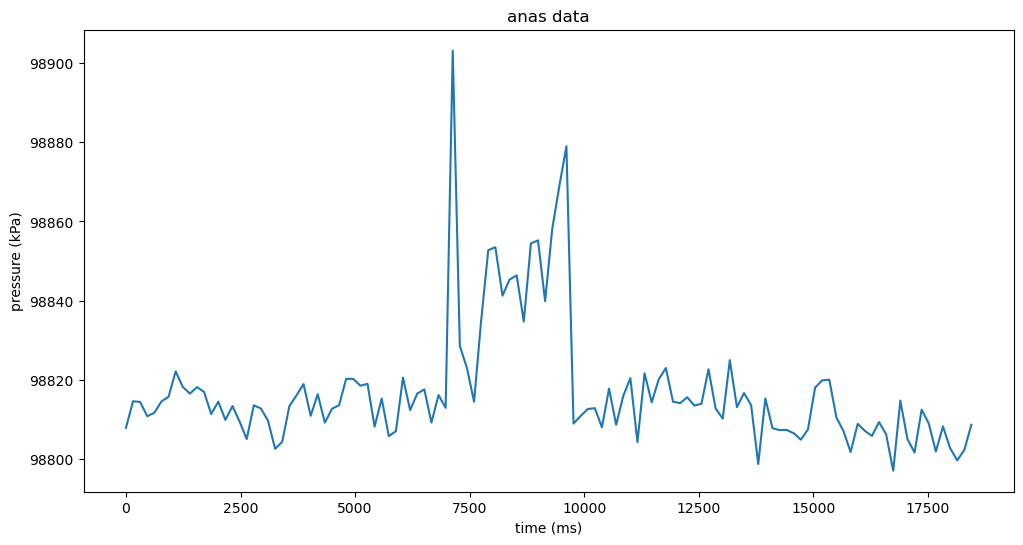

In [ ]:
#filepaths = ['bend3.csv', 'bend1.csv', 'bend2.csv']
filepath = filename
column_names = [
            "time (ms)", "pressure (kPa)"
        ]
#anas_data = pd.read_csv(filepath, names=column_names, skiprows=1)
plt.figure(figsize=(12, 6))#size of the data plot
#plt.xticks(np.arange(expert_data['time (ms)'].min(), expert_data['time (ms)'].max(), 1000.0))

p1 = sns.lineplot(data=test_df, x=test_df['time (ms)'], y=test_df['pressure (kPa)']).set_title('anas data')

### Load Expert Data into DataFrame
Preprocess to extract only breath information

/Users/lliao/Documents/REU2024/2024-REU-Neon


In [8]:
import os
paths = ['julyData/Madeline/', 'julyData/Phoenix/']
#paths = ['DataProcessing/Visualization/julyData/Rohita/', 'DataProcessing/Visualization/julyData/Roy/']
column_names = [
            "time(s)", "Acc_X", "Acc_Y", "Acc_Z","Gyr_X", "Gyr_Y", "Gyr_Z",
            "Mag_X", "Mag_Y", "Mag_Z","Temp", "pressure (kPa)", "PSI", "atm"
        ]
lines = []
for path in paths:
    for filename in os.listdir((path + 'original/')):
        #print(filename)
        lines = []
        with open(path+ 'original/' +filename, 'r') as file:
            lines = [line.rstrip() for line in file]
            lines.pop(0)
            lines.pop(0)
            lines[0] = 'time(s),' + lines[0]
            count = 1
            for l in lines:
                if 'time(s)' not in l:
                    l = str(l).split(' ')
                    
                    l[0] = l[0] + ','
                    lines[count] = l
                    count += 1
            lines.pop()
        with open(path + 'preprocess/' +filename.replace('bend','preprocess'), 'w') as f:
            for line in lines:
                new_line = ''.join(line)
                f.write(f"{new_line}\n")      


     time(s)  pressure (kPa)
0     195736        99510.18
1     196049        99505.00
2     196363        99519.10
3     196677        99509.84
4     196995        99506.45
..       ...             ...
135   238288        99511.92
136   238602        99513.09
137   238916        99500.76
138   239230        99482.48
139   239548        99505.80

[140 rows x 2 columns]
     time(s)  pressure (kPa)
0     195736        99510.18
1     196049        99505.00
2     196363        99519.10
3     196677        99509.84
4     196995        99506.45
..       ...             ...
135   238288        99511.92
136   238602        99513.09
137   238916        99500.76
138   239230        99482.48
139   239548        99505.80

[140 rows x 2 columns]
     time(s)  pressure (kPa)
0     414539        99501.44
1     414853        99504.11
2     415167        99501.99
3     415481        99502.13
4     415798        99504.55
..       ...             ...
136   457402        99516.79
137   457716        9949

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

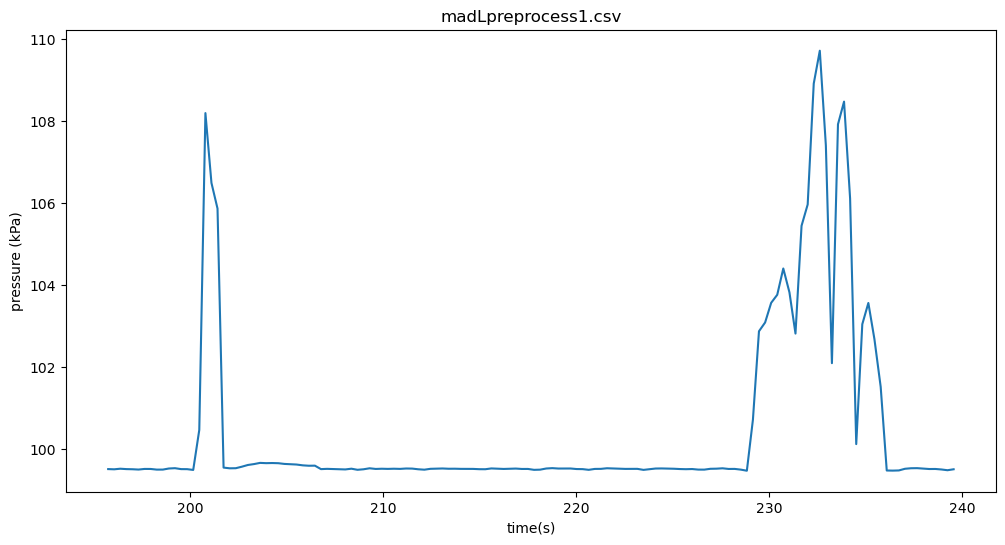

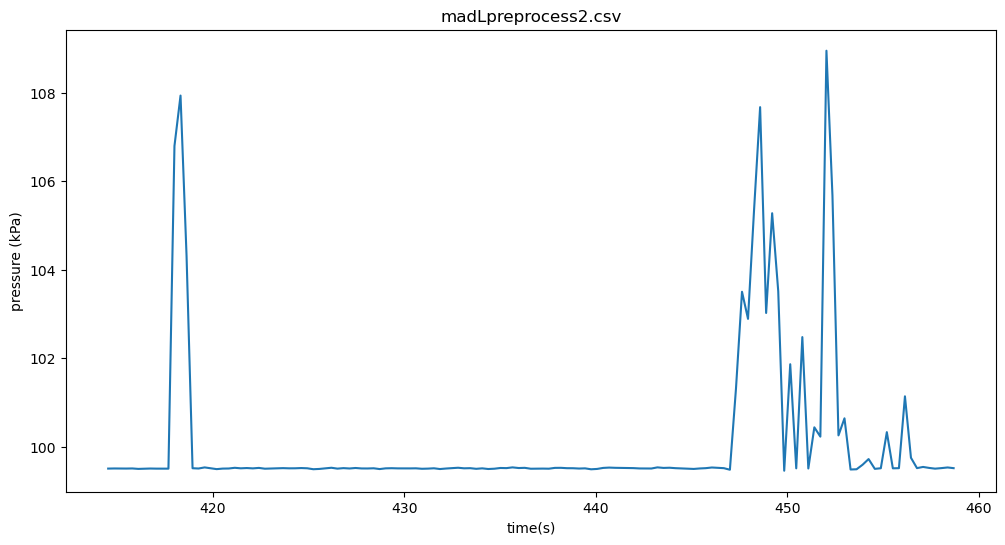

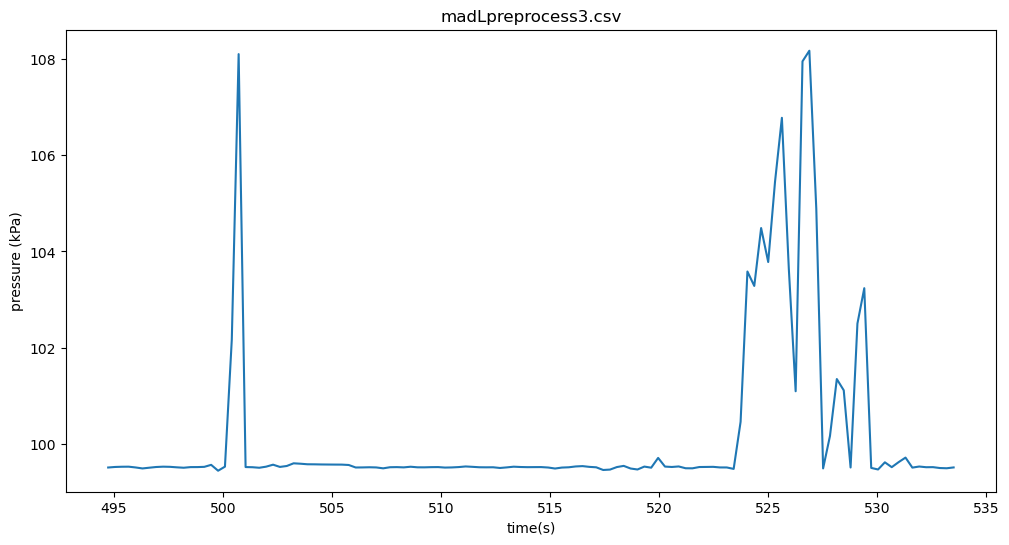

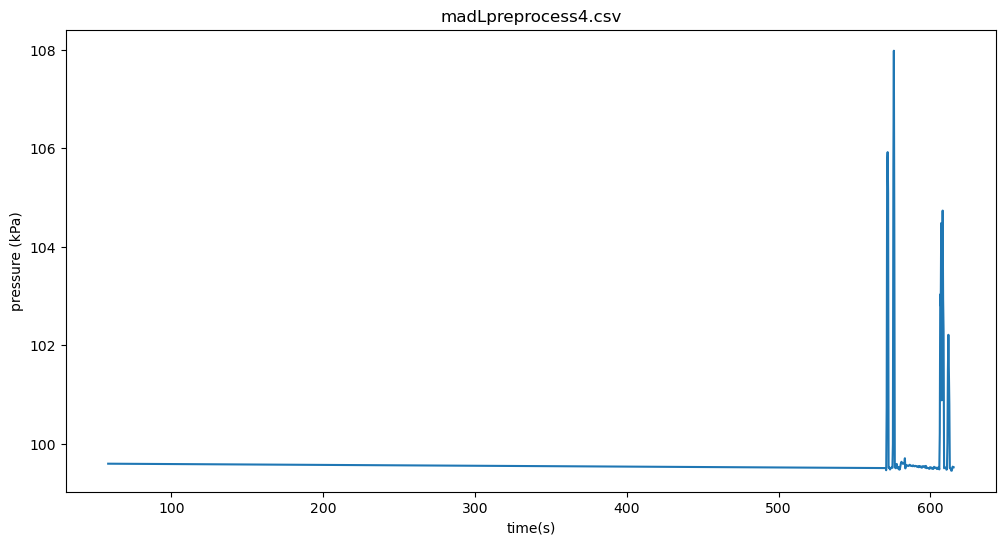

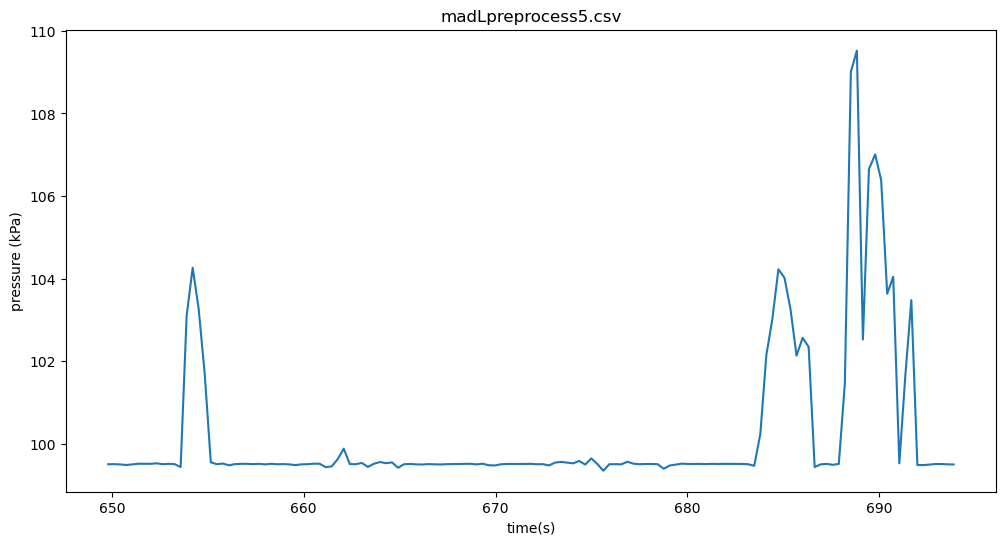

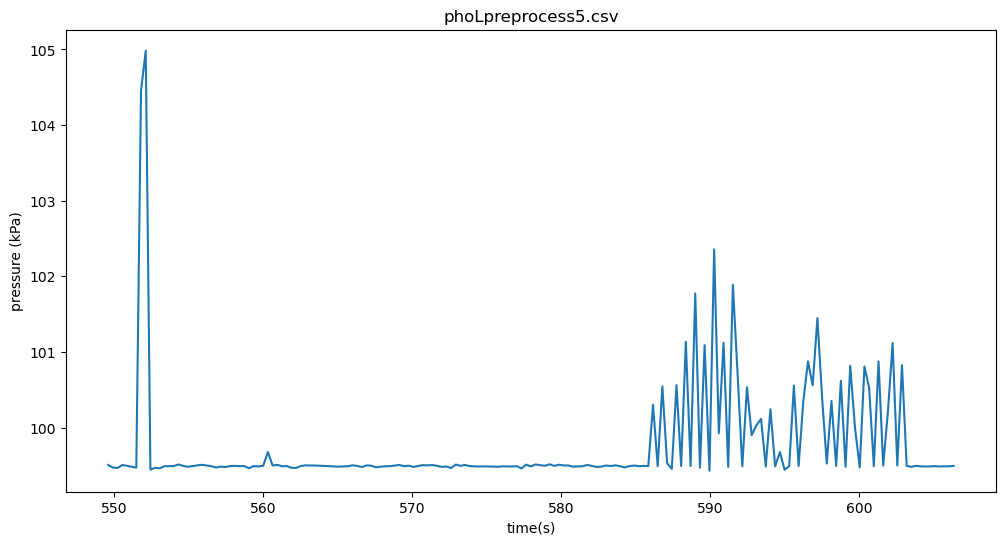

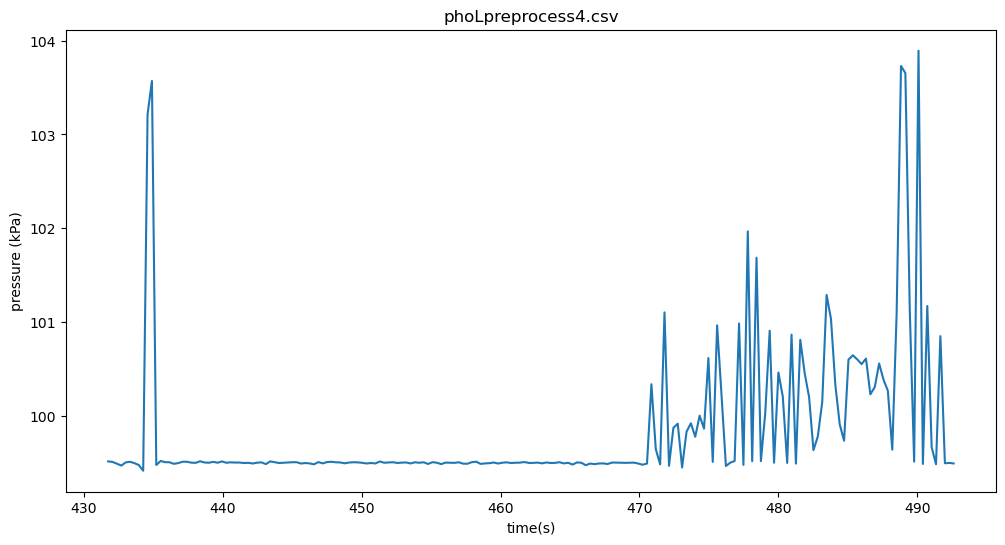

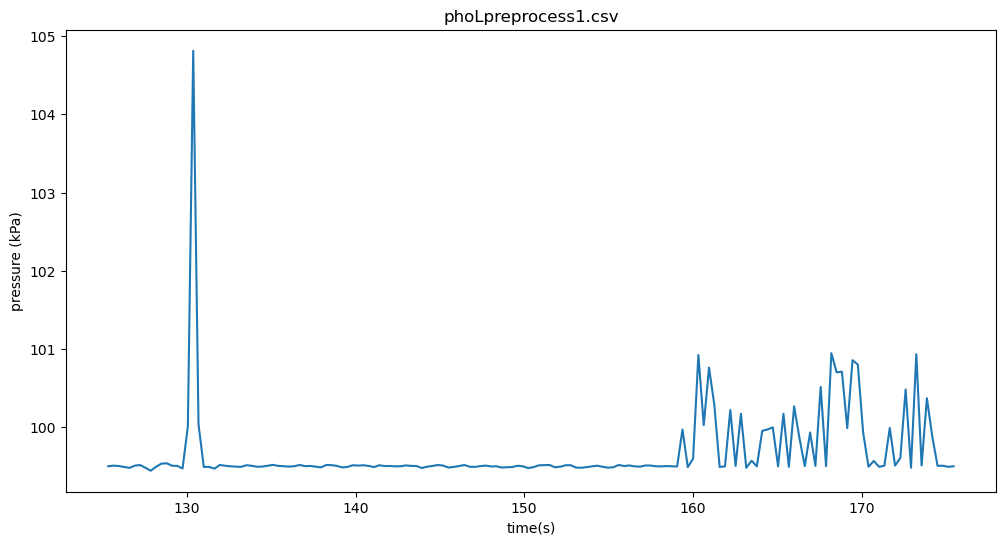

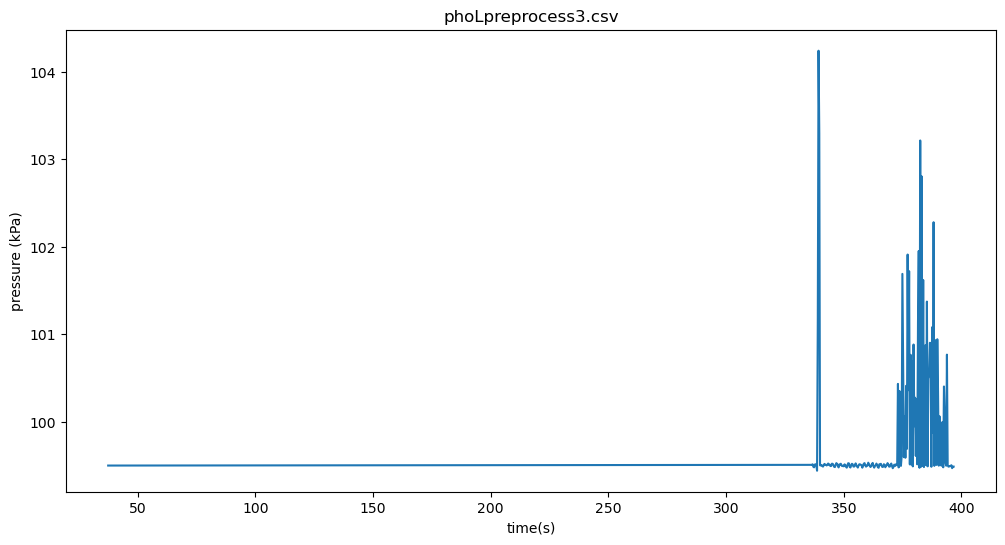

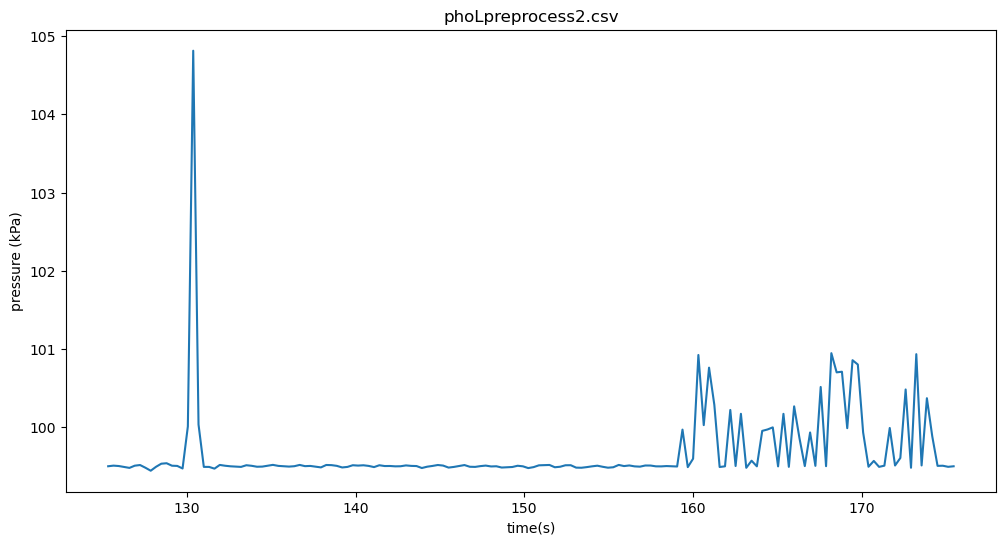

In [15]:
paths = ['julyData/Madeline/preprocess/', 'julyData/Phoenix/preprocess/', 'julyData/Rohita/original/', 'julyData/Roy/original/']

# column_names = [
#             "time(s)", "Acc_X", "Acc_Y", "Acc_Z","Gyr_X", "Gyr_Y", "Gyr_Z",
#             "Mag_X", "Mag_Y", "Mag_Z","Temp", "pressure (kPa)", "PSI", "atm"
#         ]
column_names = ['time(s)','pressure (kPa)']
lines = []
for path in paths:
    for filename in os.listdir(path):
        if "preprocess" in filename:   
            data = pd.read_csv(path+filename)
            #data[' Pa']
            print(data)
            #print(data)
            #data = data[['time(s)',' Pa']]
            data.columns = column_names
            print(data)
            #data = data[['time(s)','pressure (kPa)']]
            #data.columns = column_names
            
            data['time(s)'] /= 1000.0
            data['pressure (kPa)'] /= 1000.0
            #threshold = 99.6
            #print(path+filename)
            data.to_csv(path+filename, index=False)
            plt.figure(figsize=(12, 6))#size of the data plot
            p = sns.lineplot(data=data, x=data['time(s)'], y=data['pressure (kPa)']).set_title(filename)
            #print(data)
        
        


### Filter Out Start Spike 

madLpreprocess1.csv
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
     time(s)  pressure (kPa)
19   201.716        99.54647
20   202.034        99.52938
21   202.347        99.53142
22   202.661        99.56816
23   202.975        99.61033
..       ...             ...
135  238.288        99.51192
136  238.602        99.51309
137  238.916        99.50076
138  239.230        99.48248
139  239.548        99.50580

[121 rows x 2 columns]
julyData/Madeline/filtered/madLfiltered1.csv


/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

madLpreprocess2.csv
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
     time(s)  pressure (kPa)
14   418.945        99.50933
15   419.259        99.50331
16   419.576        99.52799
17   419.890        99.50784
18   420.204        99.48925
..       ...             ...
136  457.402        99.51679
137  457.716        99.49993
138  458.030        99.51153
139  458.370        99.52688
140  458.684        99.51098

[127 rows x 2 columns]
julyData/Madeline/filtered/madLfiltered2.csv
madLpreprocess3.csv
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
     time(s)  pressure (kPa)
20   501.042        99.51366
21   501.356        99.51048
22   501.670        99.49930
23   501.984        99.52213
24   502.302        99.56316
..       ...             ...
119  532.240        99.51060
120  532.554        99.51199
121  532.868        99.49363
122  533.182        99.48875
123  533.500        99.50607

[104 rows x 2 columns]
julyData/Madeline/filtered/madLfiltered3.csv
madLprep

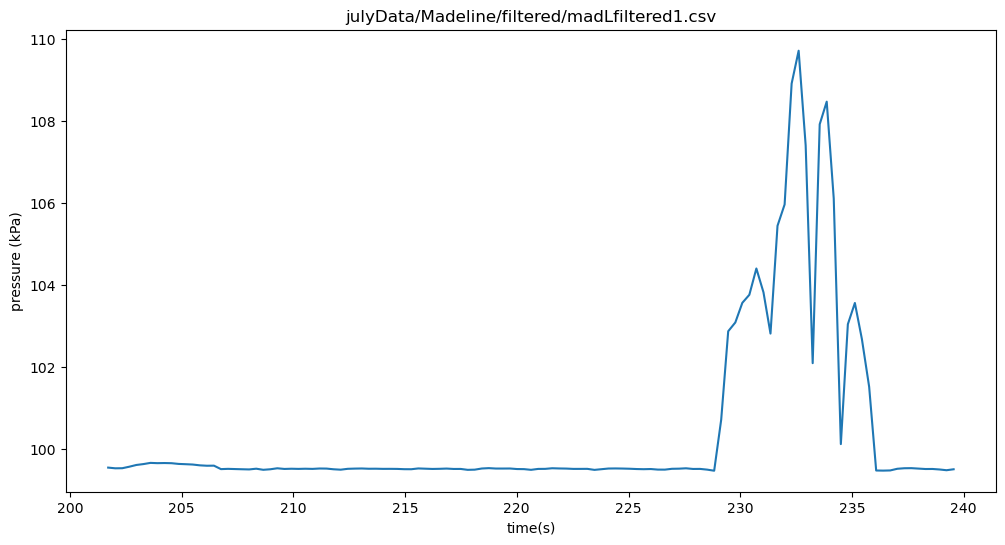

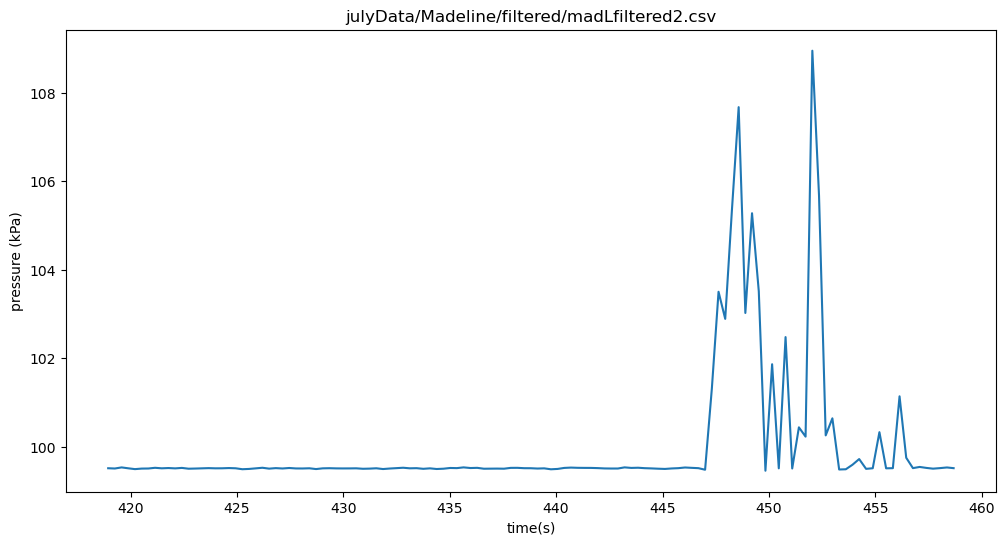

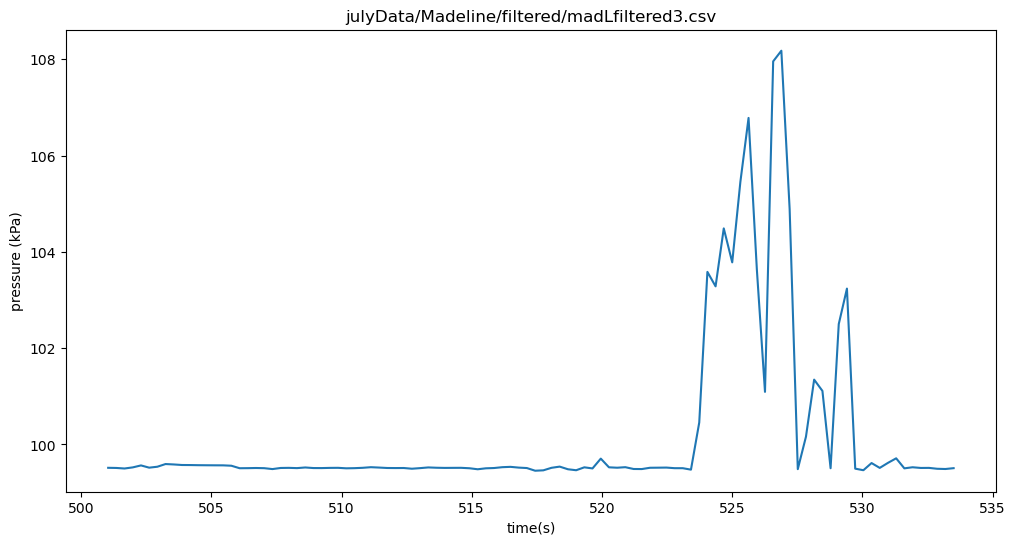

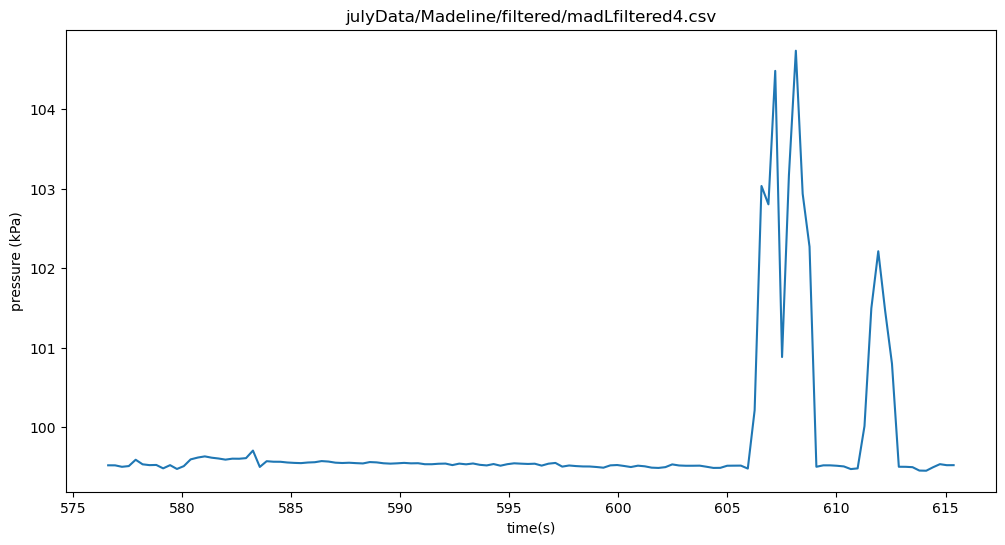

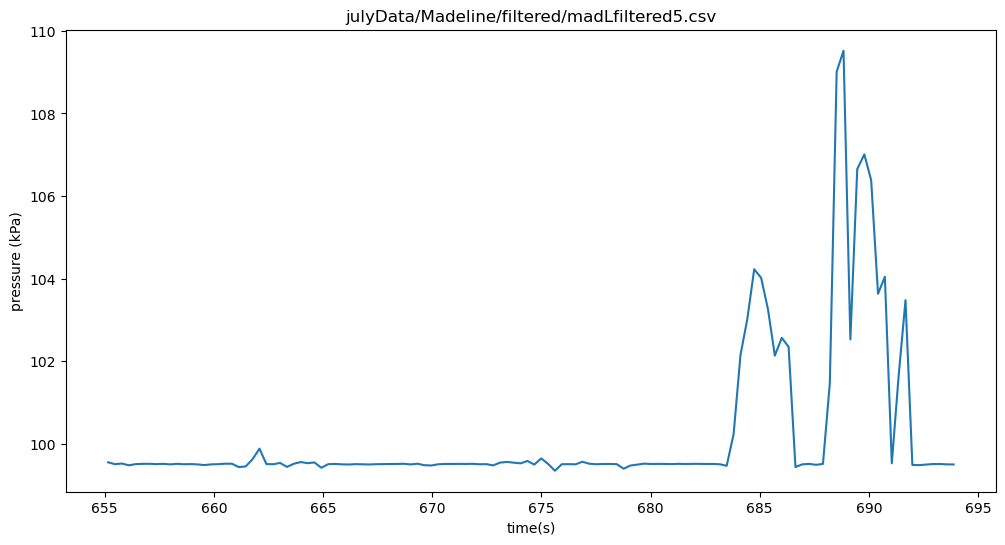

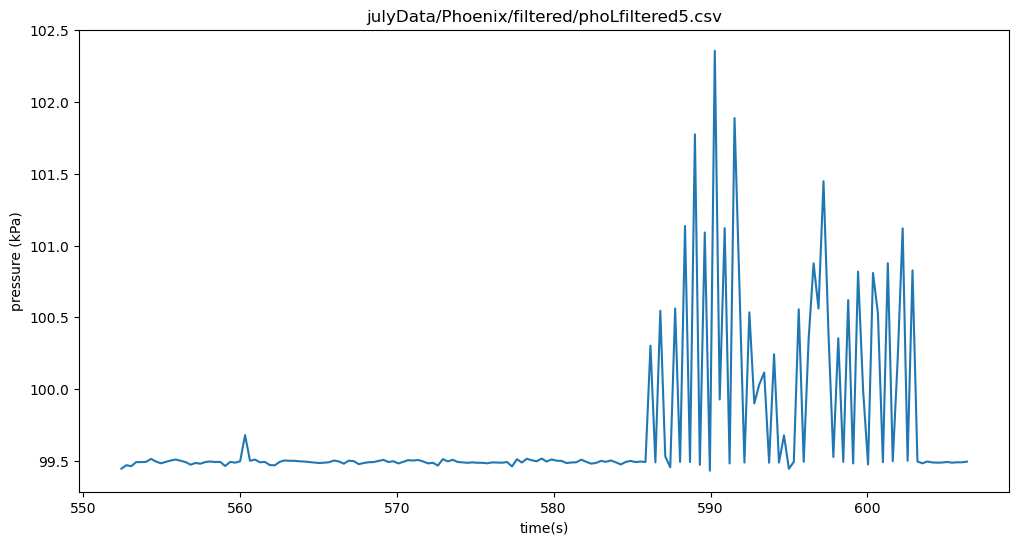

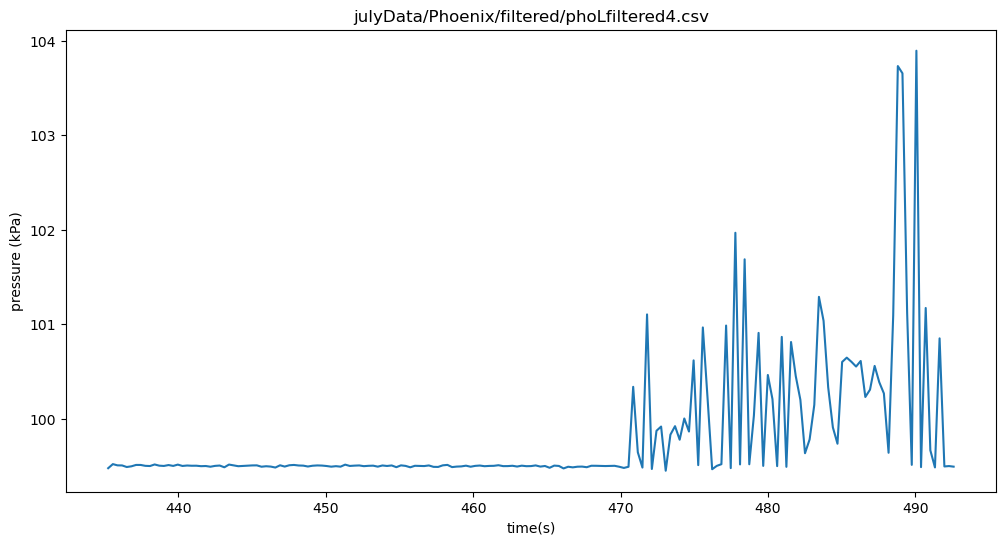

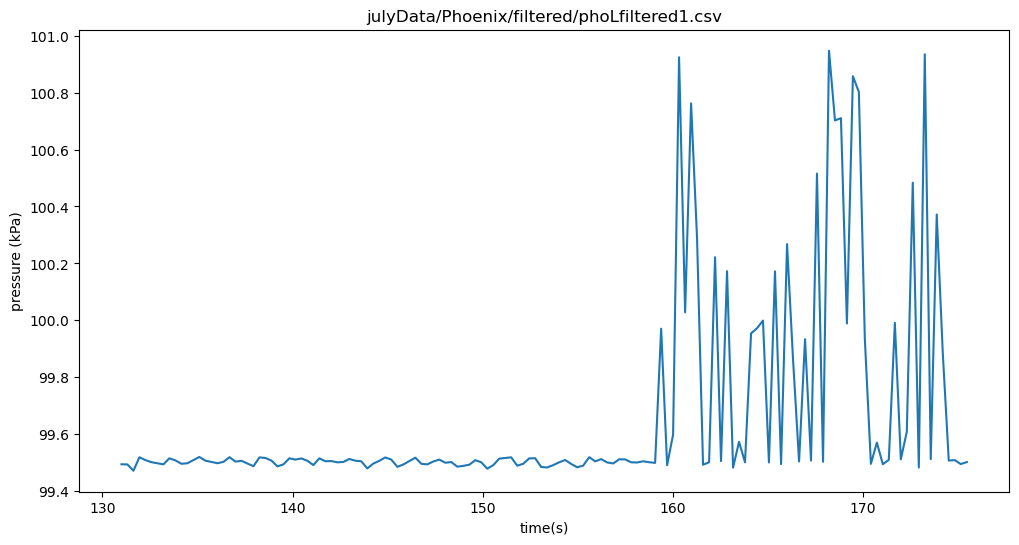

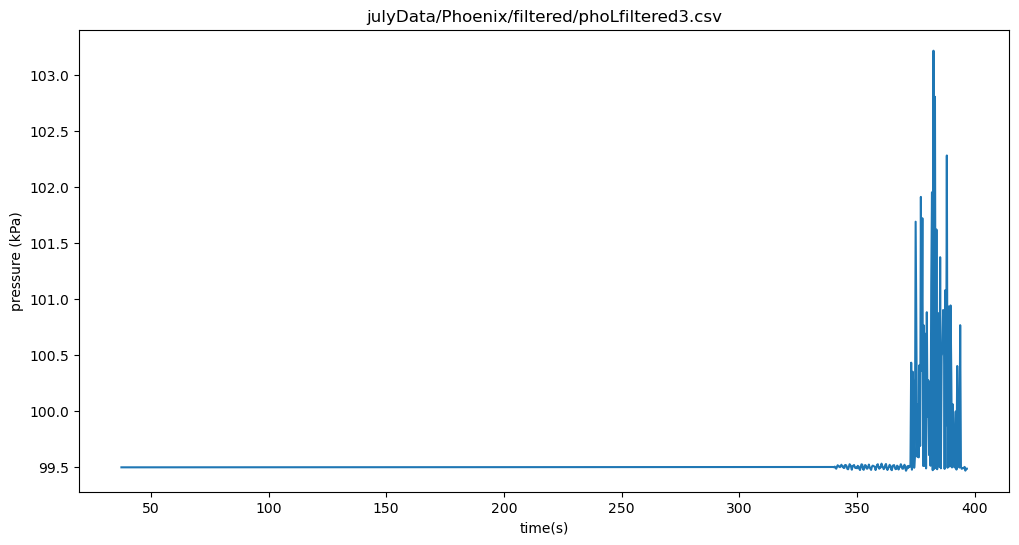

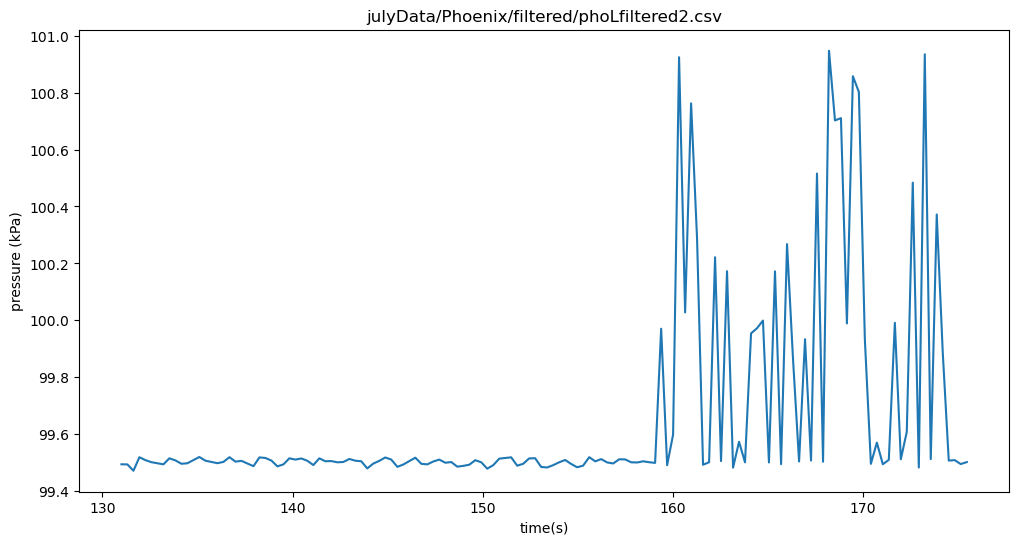

In [25]:
#paths = ['DataProcessing/Visualization/julyData/Madeline/preprocess/', 'DataProcessing/Visualization/julyData/Phoenix/preprocess/', 'DataProcessing/Visualization/julyData/Rohita/original/', 'DataProcessing/Visualization/julyData/Roy/original/']
paths = ['julyData/Madeline/preprocess/', 'julyData/Phoenix/preprocess/']
column_names = ['time(s)','pressure (kPa)']
export_base = 'DataProcessing/Visualization/julyData/'
lines = []
for path in paths:
    for filename in os.listdir(path):
        data = pd.read_csv(path+filename, names=column_names, skiprows=1)
        threshold = 99.8
        flag = False
        drop_idxs = []
        #data[::-1] reverse order
        for index, row in data.iterrows():
            if row['pressure (kPa)'] < threshold and flag == True:
                break
            elif row['pressure (kPa)'] < threshold:
                drop_idxs.append(index)
            elif row['pressure (kPa)'] > threshold: 
                flag = True
                drop_idxs.append(index)
        print(filename)        
        print(drop_idxs)
        data = data.drop(drop_idxs)
        print(data)
        export_name = path.replace('preprocess','filtered')+filename.replace('preprocess', 'filtered')
        print(export_name)
        data.to_csv(export_name, index=False)
        plt.figure(figsize=(12, 6))#size of the data plot
        # plt.xticks(np.arange(expert_data['time (ms)'].min(), expert_data['time (ms)'].max(), 1000.0))
        # plt.yticks(np.arange(98000, expert_data['pressure (Pa)'].max(), 1000.0))
        p = sns.lineplot(data=data, x=data['time(s)'], y=data['pressure (kPa)']).set_title(export_name)
        

### Blow only

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

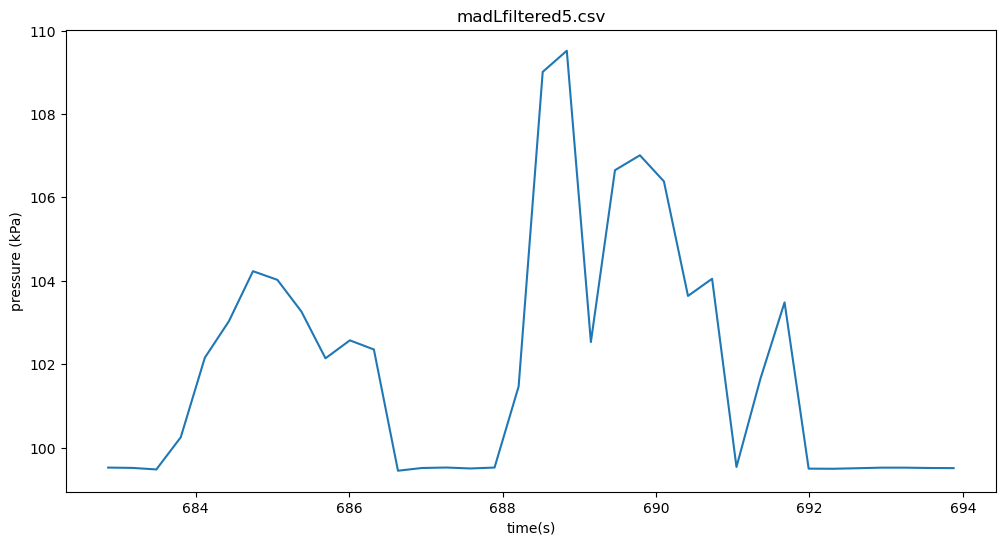

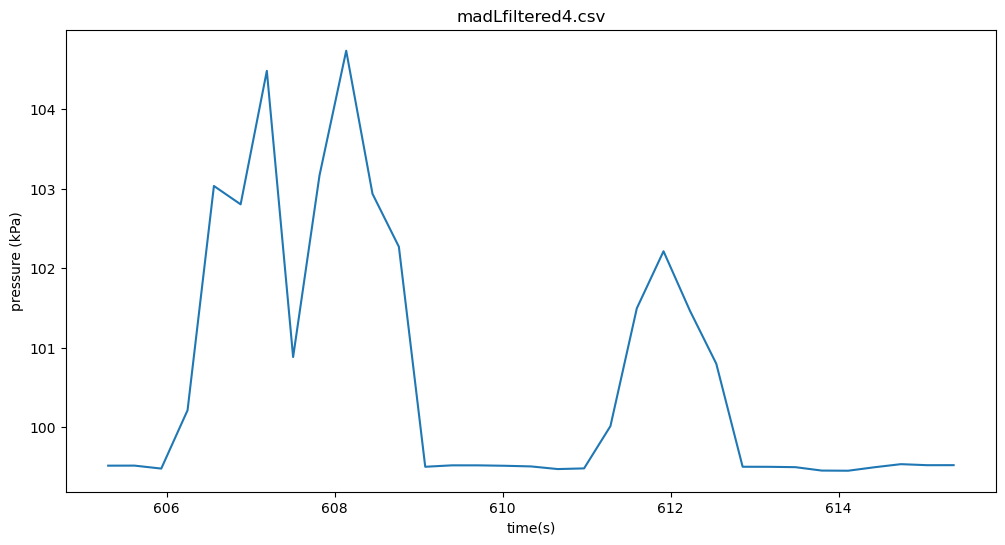

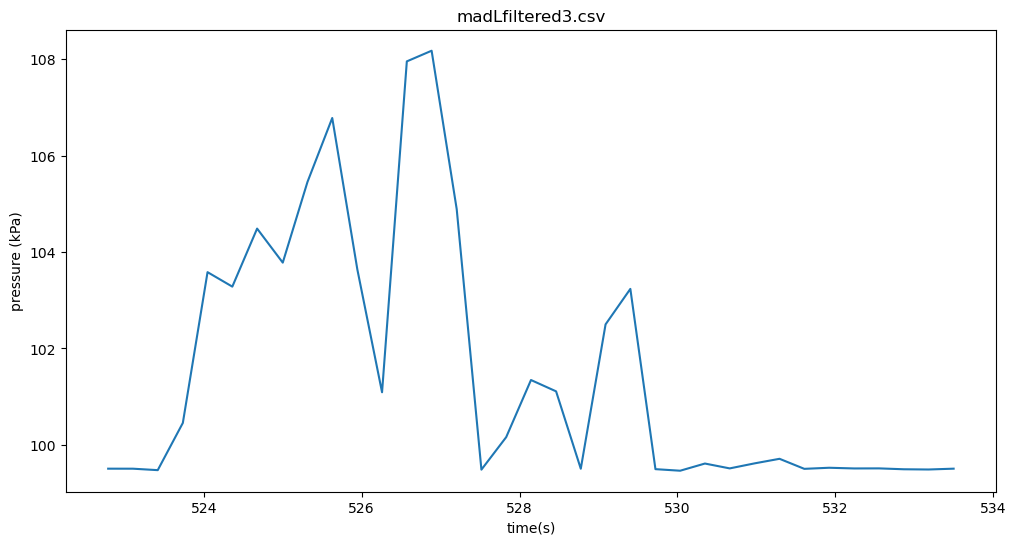

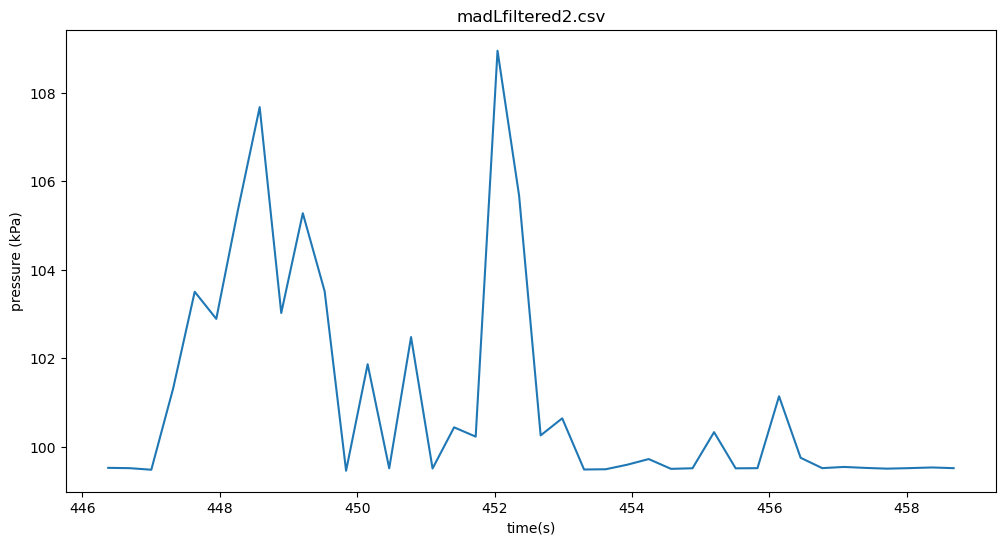

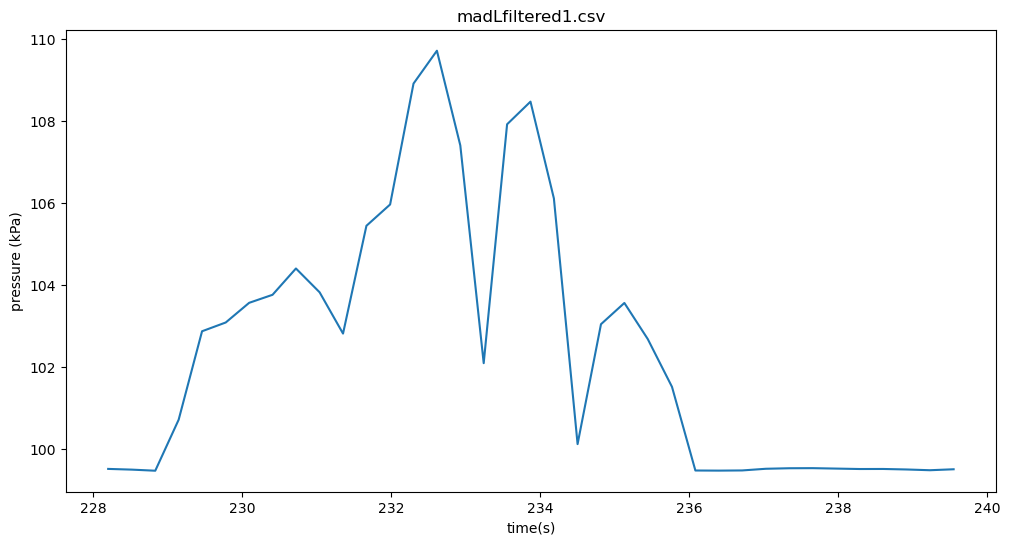

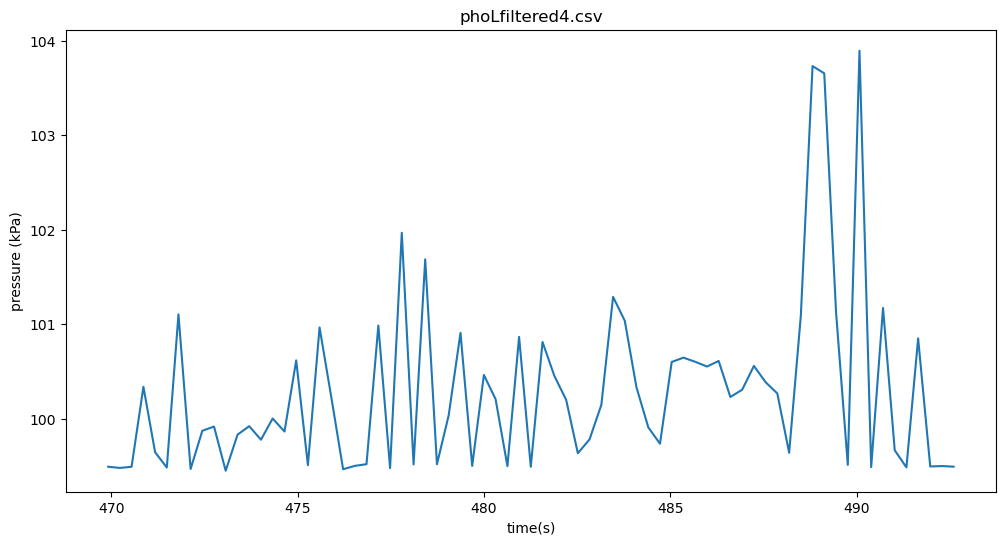

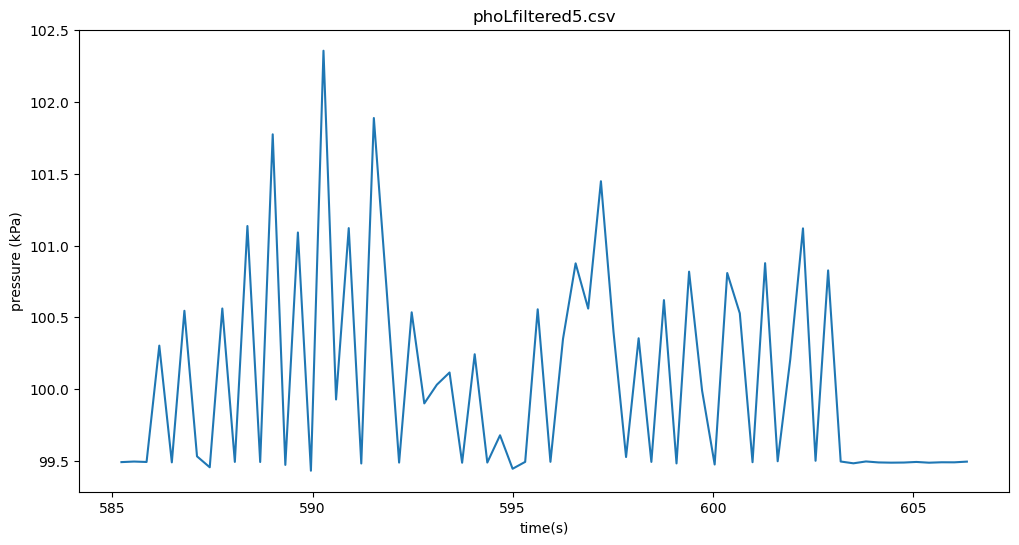

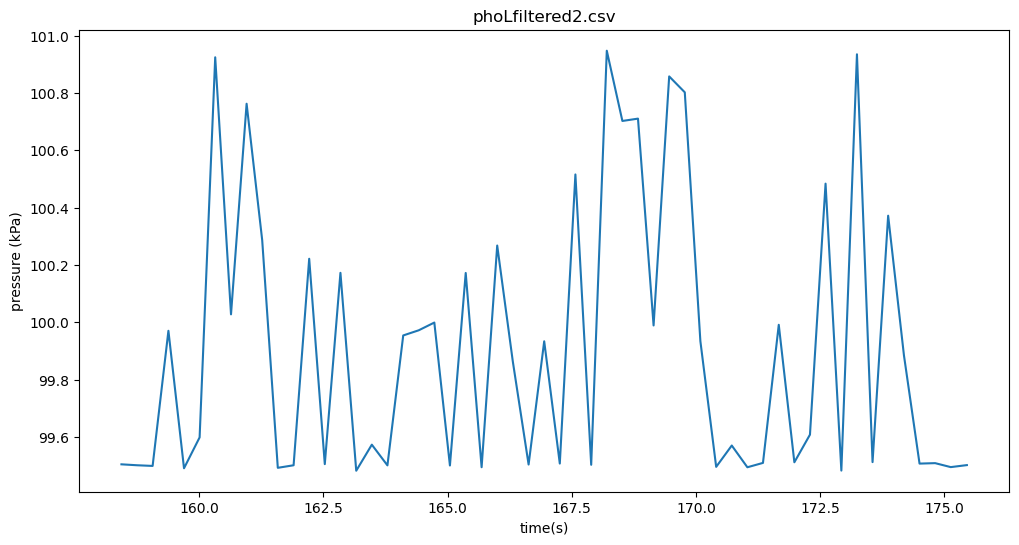

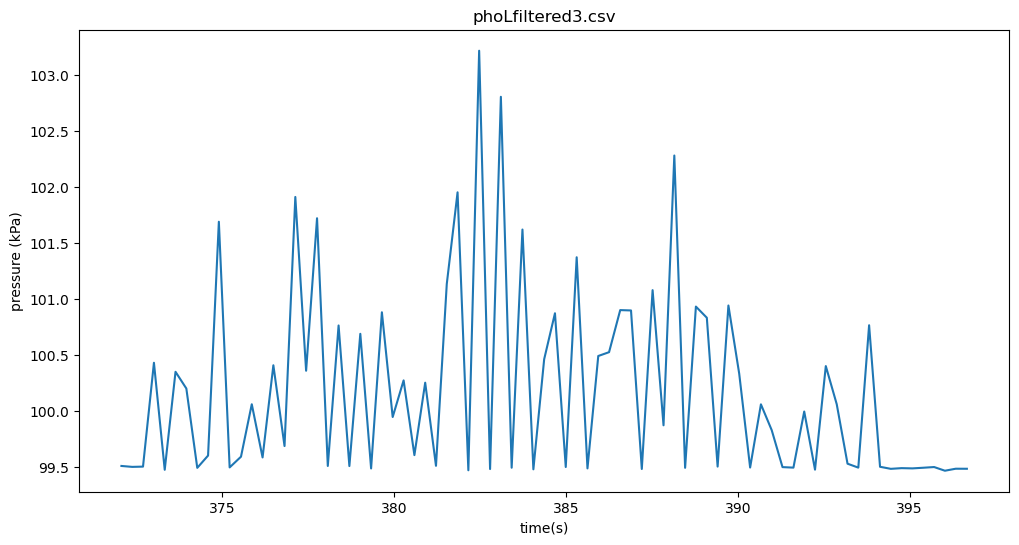

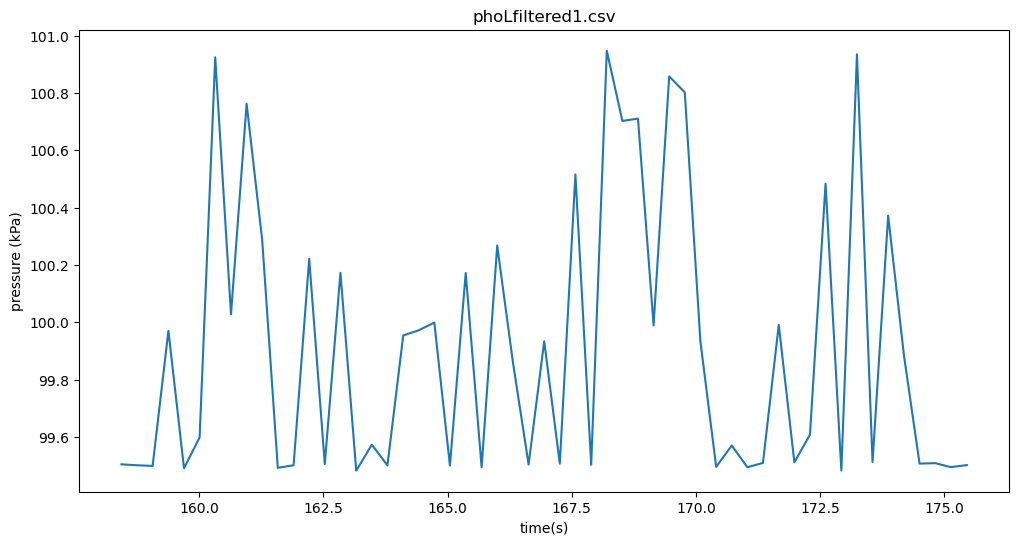

In [34]:
#paths = ['DataProcessing/Visualization/julyData/Madeline/preprocess/', 'DataProcessing/Visualization/julyData/Phoenix/preprocess/', 'DataProcessing/Visualization/julyData/Rohita/original/', 'DataProcessing/Visualization/julyData/Roy/original/']
paths = ['julyData/Madeline/filtered/', 'julyData/Phoenix/filtered/']
column_names = ['time(s)','pressure (kPa)']
export_base = 'DataProcessing/Visualization/julyData/'
lines = []
for path in paths:
    if not os.path.exists(path.replace('filtered', 'blowOnly')):
        os.mkdir(path.replace('filtered','blowOnly'))
    for filename in os.listdir(path):
        data = pd.read_csv(path+filename, names=column_names, skiprows=1)
        threshold = 99.8
        flag = False
        drop_idxs = []
        #data[::-1] reverse order
        for index, row in data.iterrows():
            if row['pressure (kPa)'] > threshold:
                drop_idxs.pop()
                drop_idxs.pop()
                drop_idxs.pop()
                break
            else:
                drop_idxs.append(index)
        print(drop_idxs)
        data = data.drop(drop_idxs)
        export_name = path.replace('filtered','blowOnly')
        data.to_csv(export_name+filename.replace('filtered','blowOnly'), index=False)
        plt.figure(figsize=(12, 6))#size of the data plot
        # plt.xticks(np.arange(expert_data['time (ms)'].min(), expert_data['time (ms)'].max(), 1000.0))
        # plt.yticks(np.arange(98000, expert_data['pressure (Pa)'].max(), 1000.0))
        p = sns.lineplot(data=data, x=data['time(s)'], y=data['pressure (kPa)']).set_title(filename)
        

In [ ]:
paths = ['./julyData/Madeline/madLbend', './julyData/Phoenix/phoLbend']
column_names = [
            "time (ms)", "Acc_X", "Acc_Y", "Acc_Z","Gyr_X", "Gyr_Y", "Gyr_Z",
            "Mag_X", "Mag_Y", "Mag_Z","Temp", "pressure (Pa)", "PSI", "atm"
        ]
for path in paths:
    for filename in os.listdir(path):
        expert_data_all = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels
        expert_data = expert_data_all[['time (ms)', 'pressure (Pa)']]
        expert_data['time (ms)'] /= 1000
        
for filepath in filepaths:
    expert_data_all = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels
    expert_data = expert_data_all[['time (ms)', 'pressure (Pa)']]
    threshold = 99000 # Pa
    drop_idxs = []
    remove_flag = False
    for i in range(len(expert_data)):
        if remove_flag and expert_data.iloc[i, 1] > threshold:
            break
        if expert_data.iloc[i, 1] > threshold:
            drop_idxs.append(i) # Pa is on column 1 
            remove_flag = True
    expert_data = expert_data.drop(drop_idxs)
    #expert_data = expert_data.rename(columns={'time (ms)':'time (s)', 'pressure (Pa)':'pressure (kPa)'})
    export_name = filepath.replace('.csv', '') + 'filtered.csv'
    expert_data['time (ms)'] = expert_data["time (ms)"] - expert_data['time (ms)'].iloc[0]
    expert_data.to_csv(export_name, index=False)
    

### Graph Expert & Trial Data

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

<Figure size 1200x600 with 0 Axes>

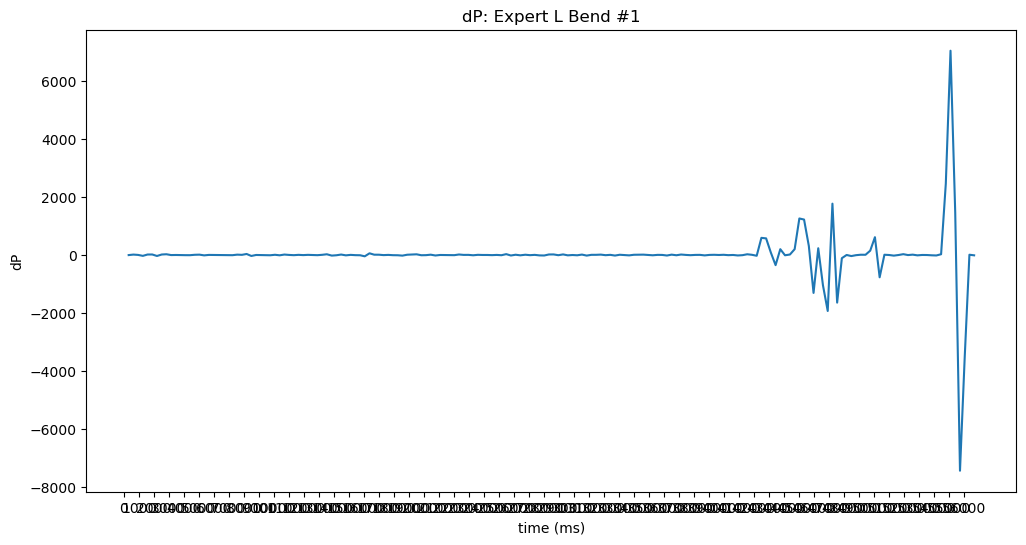

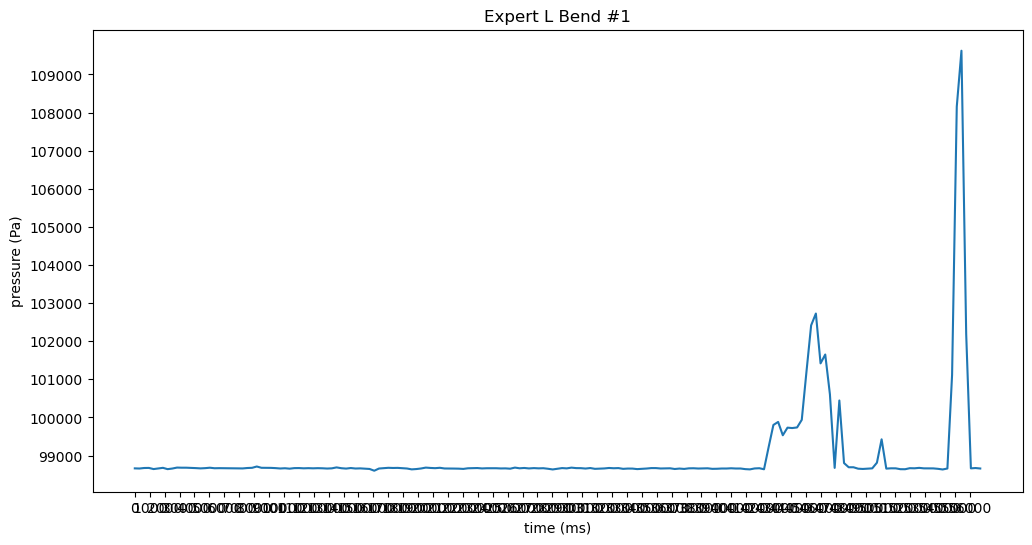

<Figure size 1200x600 with 0 Axes>

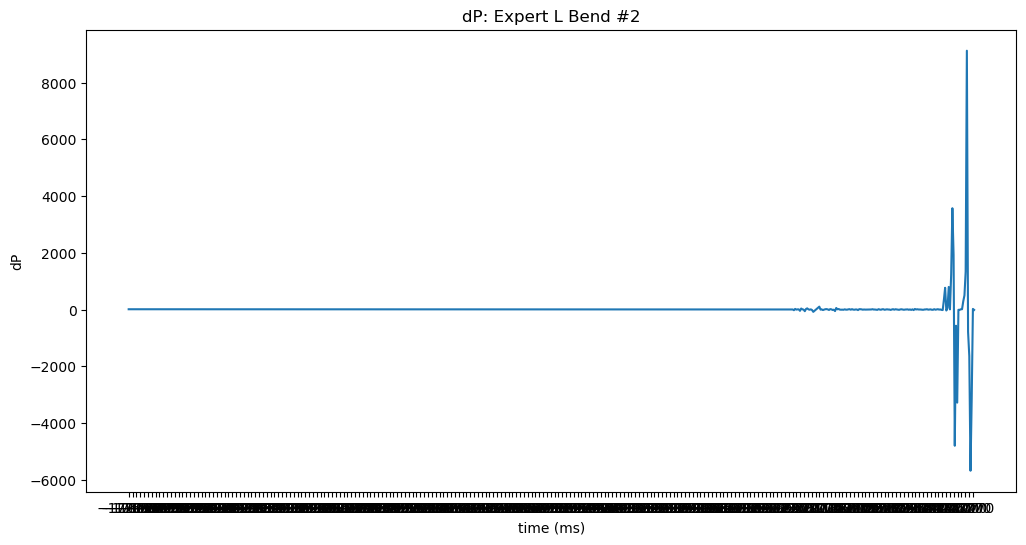

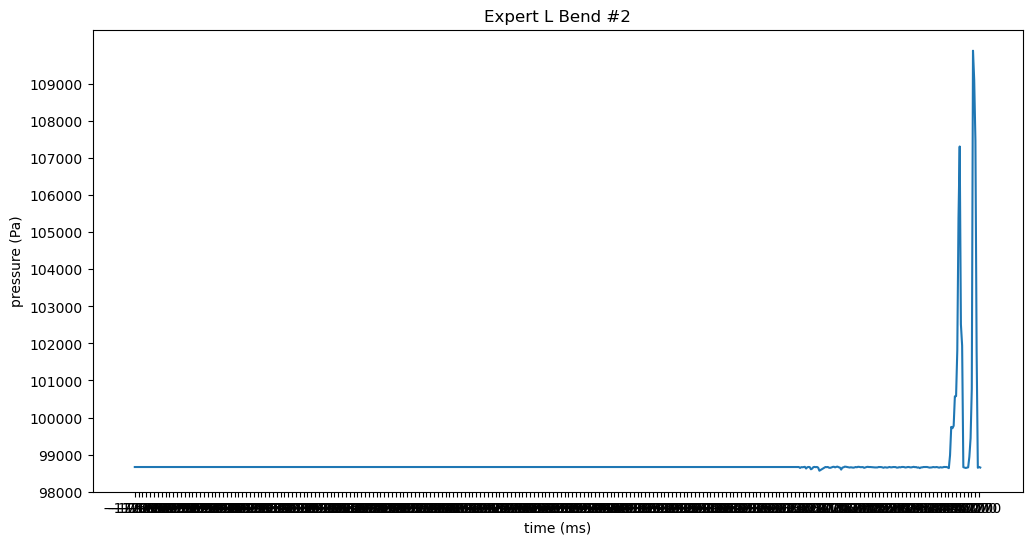

<Figure size 1200x600 with 0 Axes>

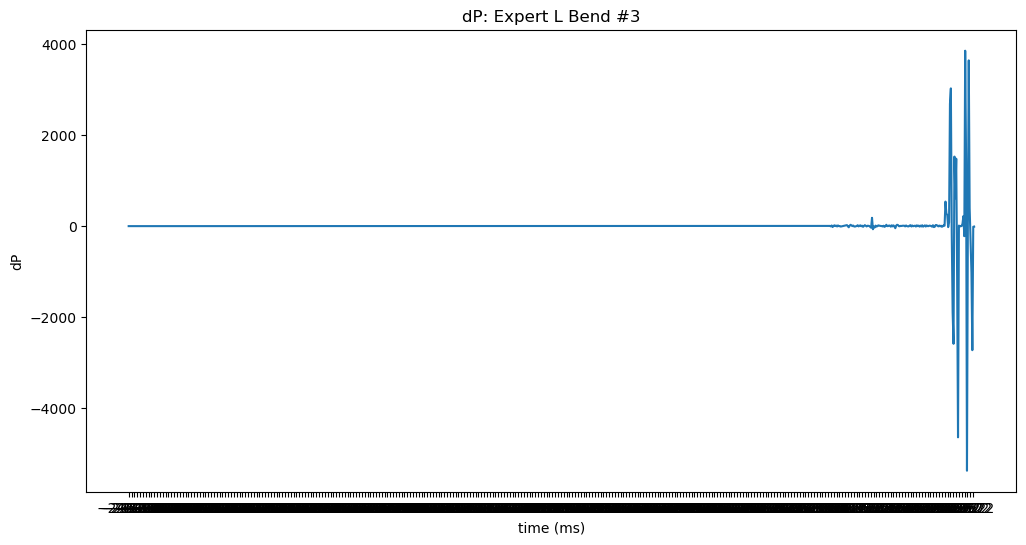

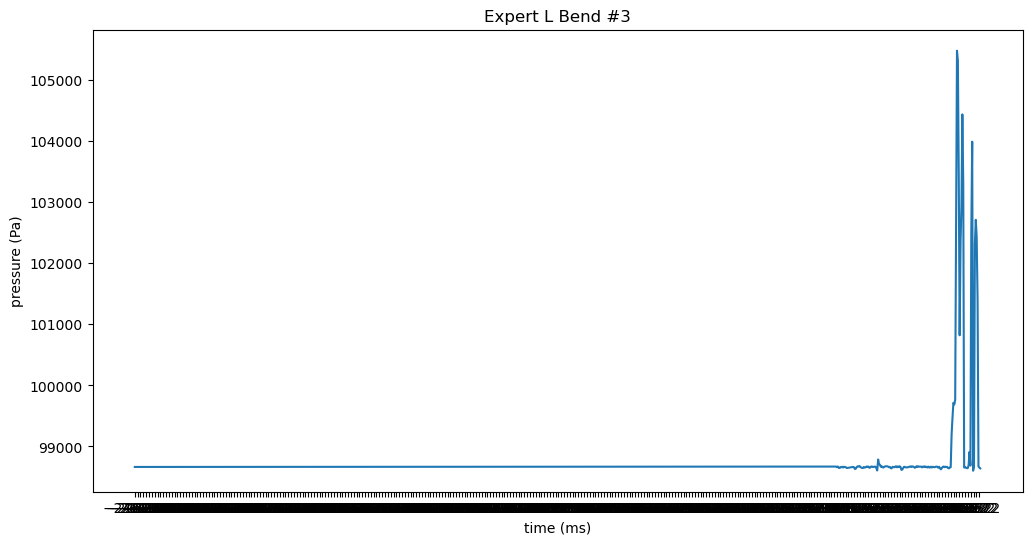

<Figure size 1200x600 with 0 Axes>

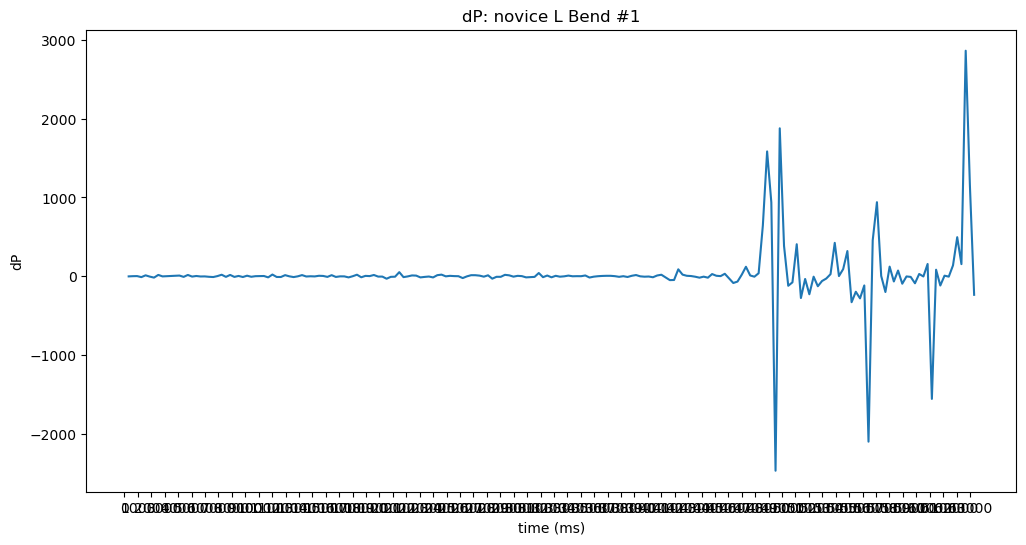

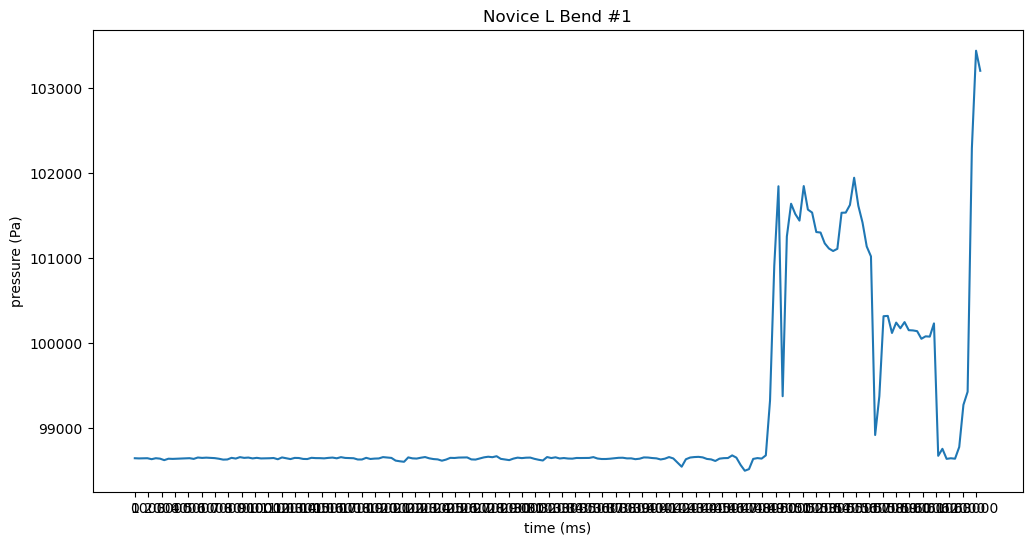

<Figure size 1200x600 with 0 Axes>

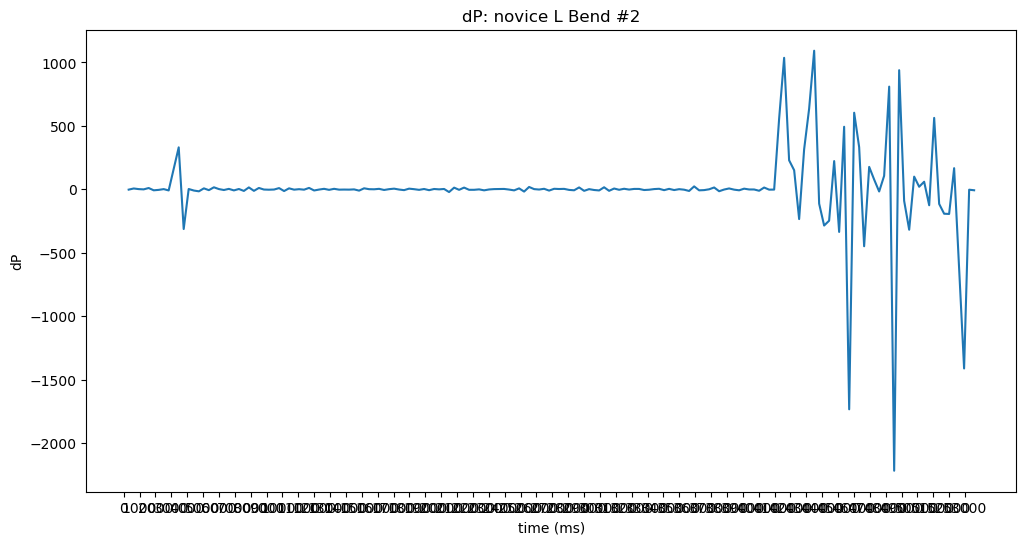

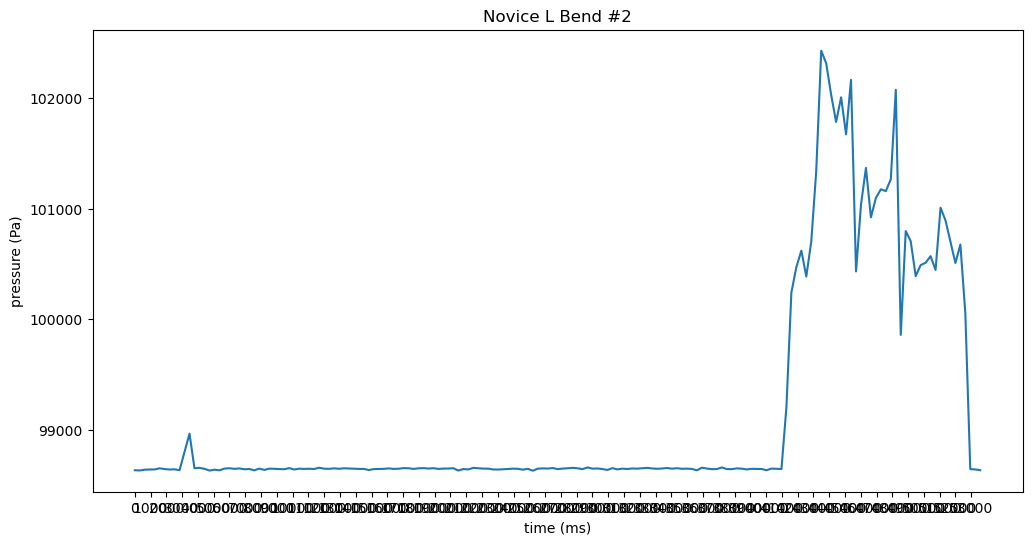

In [ ]:
#size of the data plot
#sns.lineplot(data=test_df, x=test_df['time (ms)'], y=test_df['pressure (kPa)'])
plots = []
filepaths = ['bend1dtwfiltered.csv', 'bend2dtwfiltered.csv', 'bend3dtwfiltered.csv']
#filepaths = ['bend1filtered.csv', 'bend2filtered.csv', 'bend3filtered.csv']
count = 1
for filepath in filepaths:
    plt.figure(figsize=(12, 6))
    expert_data = pd.read_csv(filepath, names=column_names, skiprows=1)
    expert_data["dt"] = expert_data["time (ms)"].diff()
    expert_data["dP"] = expert_data["pressure (Pa)"].diff()
    plt.figure(figsize=(12, 6))#size of the data plot
    plt.xticks(np.arange(expert_data['time (ms)'].min(), expert_data['time (ms)'].max(), 1000.0))
    
    p1 = sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['dP']).set_title('dP: Expert L Bend #' + str(count))

    plt.figure(figsize=(12, 6))#size of the data plot
    plt.xticks(np.arange(expert_data['time (ms)'].min(), expert_data['time (ms)'].max(), 1000.0))
    plt.yticks(np.arange(98000, expert_data['pressure (Pa)'].max(), 1000.0))
    p = sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['pressure (Pa)'])
    p.set_title('Expert L Bend #' + str(count))
    plots.append(p)
    plots.append(p1)
    count+=1

    
rohfilepaths = ['RohL_bend1dtwfiltered.csv', 'RohL_rbend2dtwfiltered.csv']

rohdata = pd.read_csv('RohL_bend1dtwfiltered.csv', names = column_names, skiprows=1)
count = 1
for filepath in rohfilepaths:
    
    plt.figure(figsize=(12, 6))
    rohdata = pd.read_csv(filepath, names=column_names, skiprows=1)
    rohdata["dt"] = rohdata["time (ms)"].diff()
    rohdata["dP"] = rohdata["pressure (Pa)"].diff()

    plt.figure(figsize=(12, 6))#size of the data plot
    plt.xticks(np.arange(rohdata['time (ms)'].min(), rohdata['time (ms)'].max(), 1000.0))
    
    p1 = sns.lineplot(data=rohdata, x=rohdata['time (ms)'], y=rohdata['dP']).set_title('dP: novice L Bend #' + str(count))

    plt.figure(figsize=(12, 6))#size of the data plot
    plt.xticks(np.arange(rohdata['time (ms)'].min(), rohdata['time (ms)'].max(), 1000.0))
    plt.yticks(np.arange(98000, expert_data['pressure (Pa)'].max(), 1000.0))
    p = sns.lineplot(data=rohdata, x=rohdata['time (ms)'], y=rohdata['pressure (Pa)'])
    p.set_title('Novice L Bend #' + str(count))
    plots.append(p)
    count+=1


/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Expert L Bend #1')

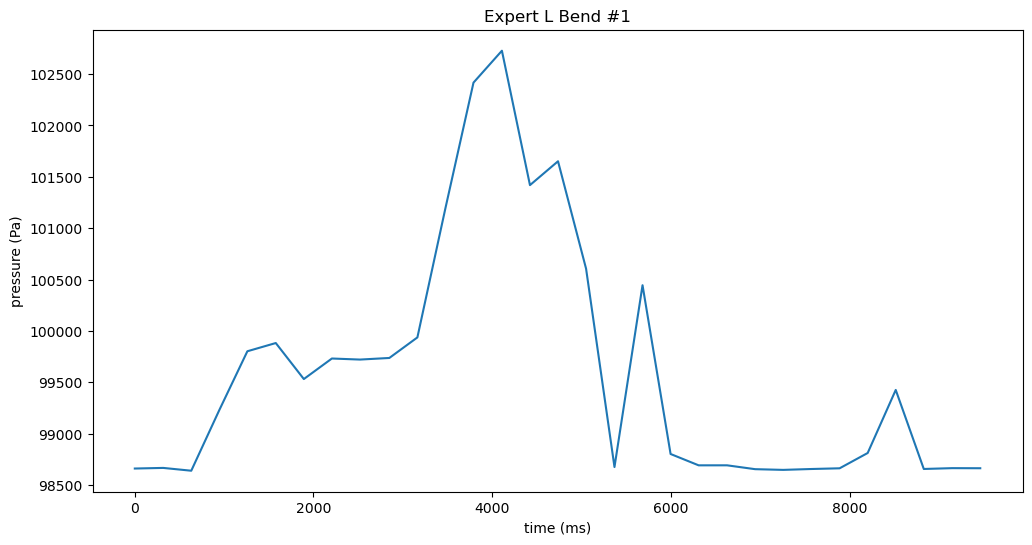

In [ ]:
plt.figure(figsize=(12, 6))#size of the data plot
#sns.lineplot(data=test_df, x=test_df['time (ms)'], y=test_df['pressure (kPa)'])
expert_data = pd.read_csv('bend1dtwfiltered.csv', names=column_names, skiprows=1)
sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['pressure (kPa)']).set_title('Expert L Bend #1')

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

([<matplotlib.axis.XTick at 0x289257c50>,
 [Text(0.0, 0, '0'),
  Text(1000.0, 0, '1000'),
  Text(2000.0, 0, '2000'),
  Text(3000.0, 0, '3000'),
  Text(4000.0, 0, '4000'),
  Text(5000.0, 0, '5000'),
  Text(6000.0, 0, '6000'),
  Text(7000.0, 0, '7000'),
  Text(8000.0, 0, '8000'),
  Text(9000.0, 0, '9000'),
  Text(10000.0, 0, '10000'),
  Text(11000.0, 0, '11000'),
  Text(12000.0, 0, '12000'),
  Text(13000.0, 0, '13000')])

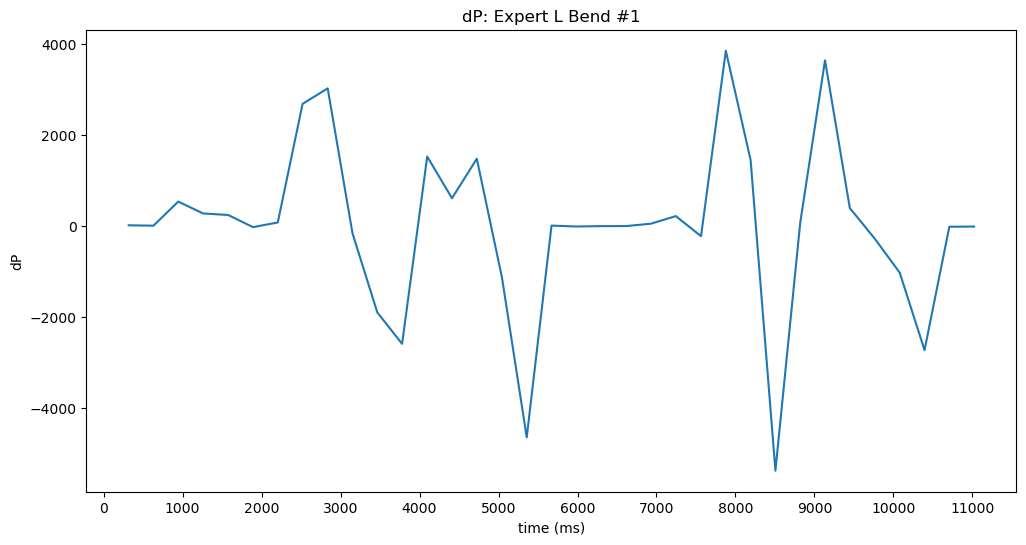

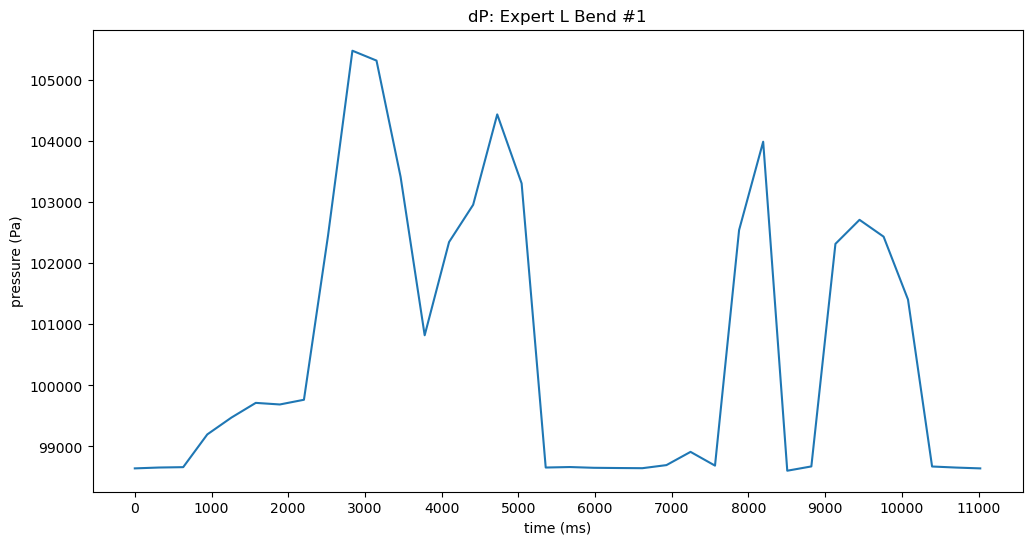

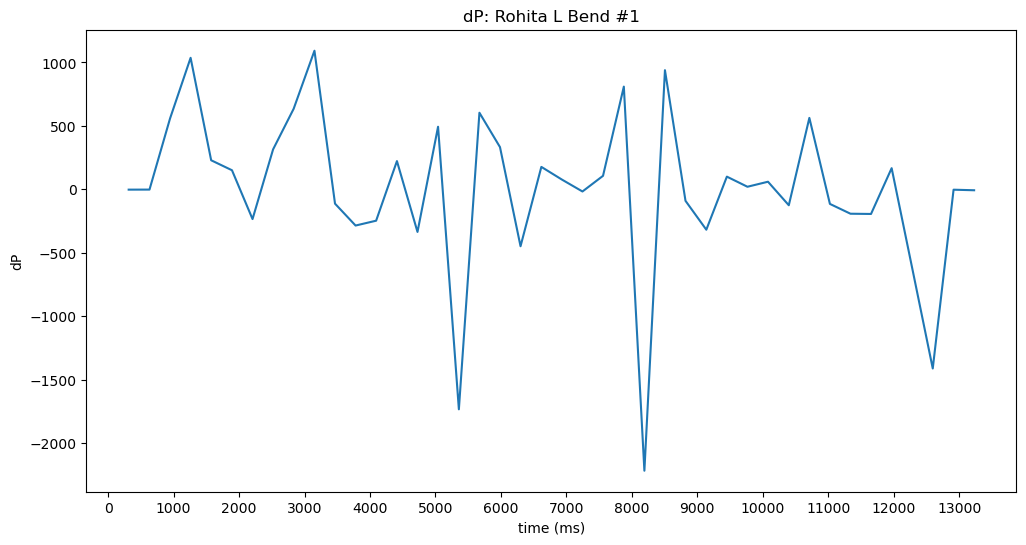

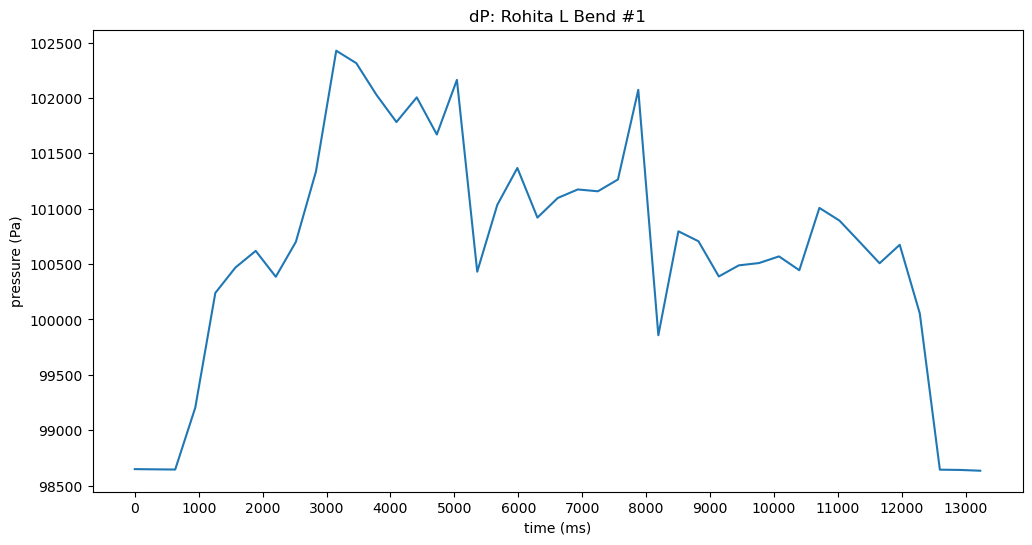

In [ ]:
# expert_data["dt"] = 
expert_data["dt"] = expert_data["time (ms)"].diff()
expert_data["dP"] = expert_data["pressure (kPa)"].diff()
rohdata["dt"] = rohdata["time (ms)"].diff()
rohdata["dP"] = rohdata["pressure (kPa)"].diff()

# expert_data
plt.figure(figsize=(12, 6))#size of the data plot
sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['dP']).set_title('dP: Expert L Bend #1')
plt.xticks(np.arange(expert_data['time (ms)'].min(), expert_data['time (ms)'].max(), 1000.0))
plt.figure(figsize=(12, 6))#size of the data plot
sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['pressure (kPa)']).set_title('dP: Expert L Bend #1')
plt.xticks(np.arange(expert_data['time (ms)'].min(), expert_data['time (ms)'].max(), 1000.0))
plt.figure(figsize=(12, 6))#size of the data plot

sns.lineplot(data=rohdata, x=rohdata['time (ms)'], y=rohdata['dP']).set_title('dP: Rohita L Bend #1')
plt.xticks(np.arange(rohdata['time (ms)'].min(), rohdata['time (ms)'].max(), 1000.0))
plt.figure(figsize=(12, 6))#size of the data plot
sns.lineplot(data=rohdata, x=rohdata['time (ms)'], y=rohdata['pressure (kPa)']).set_title('dP: Rohita L Bend #1')
plt.xticks(np.arange(rohdata['time (ms)'].min(), rohdata['time (ms)'].max(), 1000.0))



### Feature extraction

In [ ]:
import pandas as pd
import os
from scipy.signal import find_peaks
def get_features(filepath):
    #basepath = '/content/drive/MyDrive/The Hybrid Atelier/REU2024/1 - Project Folders/Rohita & Roy/2 - Data Collection/Collab Data Visualization/'

    if not os.path.isfile(filepath):
        print(f"{filepath} not working.")

    # reads all the data into the data frame along with all the varaiables
    column_names = [
        "time (ms)","pressure (kPa)"
    ]
    data = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels
    features = {
        'min_Pa': -1,
        'max_Pa': -1,
        'num_peaks': -1,
        'blow_duration': -1,
        'mean_pa': -1
    }
    features['blow_duration'] = data["time (ms)"].max()
    features['min_Pa'] = data['pressure (kPa)'].min()
    features['max_Pa'] = data['pressure (kPa)'].max()
    features['mean_pa'] = data['pressure (kPa)'].mean()
    peaks, _ = find_peaks(data['pressure (kPa)'].to_numpy(), threshold=100)
    print(peaks)
    
    #print(data)
    #will basically equalize the time
    #data["time (ms)"] = data["time (ms)"] - data["time (ms)"].iloc[0]
    return features

filepaths_expert = ['bend1dtwfiltered.csv', 'bend2dtwfiltered.csv', 'bend3dtwfiltered.csv']
novicepaths = ['RohL_bend1dtwfiltered.csv', 'RohL_rbend2dtwfiltered.csv']
expert_min = []
expert_max = []
expert_mean = []
expert_duration = []
novice_min = []
novice_max = []
novice_mean = []
novice_duration = []
for filepath in filepaths_expert:
    feat = get_features(filepath)
    #feat = pd.DataFrame(feat.items(), columns=list(feat.keys))
    expert_min.append(feat['min_Pa'])
    expert_max.append(feat['max_Pa'])
    expert_mean.append(feat['mean_pa'])
    expert_duration.append(feat['blow_duration'])
for filepath in novicepaths:
    feat = get_features(filepath)
    novice_min.append(feat['min_Pa'])
    novice_max.append(feat['max_Pa'])
    novice_mean.append(feat['mean_pa'])
    novice_duration.append(feat['blow_duration'])
novice_stats = []
novice_stats.append(np.mean(novice_min))
novice_stats.append( np.mean(novice_max))
novice_stats.append( np.mean(novice_mean))
novice_stats.append(np.mean(novice_duration))
expert_stats = []
expert_stats.append(np.mean(expert_min))
expert_stats.append(np.mean(expert_max))
expert_stats.append(np.mean(expert_mean))
expert_stats.append(np.mean(expert_duration))
print(expert_stats)
print(novice_stats)



[13 15 18 27]
[10 21]
[ 9 15 23 26 30]
[ 5  8 11 23 42 50]
[ 6 10 14 16 19 25 34 38]
[98625.77, 106036.76000000001, 100461.11578938384, 9662.333333333334]
[98636.91, 102186.66500000001, 100483.81717799642, 15114.0]


### DTW analysis

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

RohL_bend1dtwfiltered.csv RohL_rbend2dtwfiltered.csv: 252.82242105263163
RohL_bend1dtwfiltered.csv bend1dtwfiltered.csv: 227.24662650602218
RohL_bend1dtwfiltered.csv bend2dtwfiltered.csv: 790.2295000000001
RohL_bend1dtwfiltered.csv bend3dtwfiltered.csv: 746.6444318181827
RohL_rbend2dtwfiltered.csv bend1dtwfiltered.csv: 283.1701351351345
RohL_rbend2dtwfiltered.csv bend2dtwfiltered.csv: 833.9967605633799
RohL_rbend2dtwfiltered.csv bend3dtwfiltered.csv: 791.5106329113936
bend1dtwfiltered.csv bend2dtwfiltered.csv: 760.9301694915265
bend1dtwfiltered.csv bend3dtwfiltered.csv: 594.6220895522387
bend2dtwfiltered.csv bend3dtwfiltered.csv: 748.3431249999996


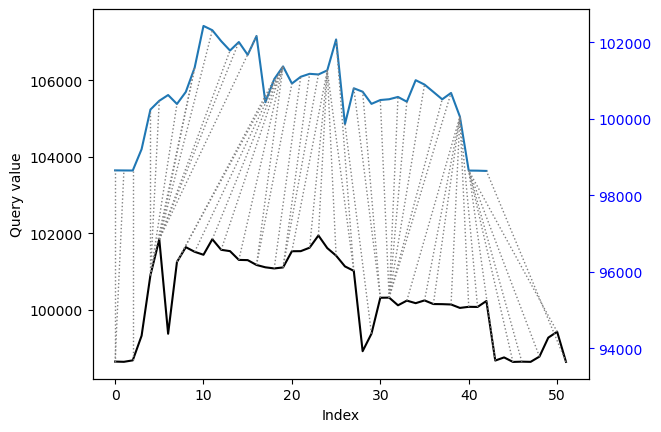

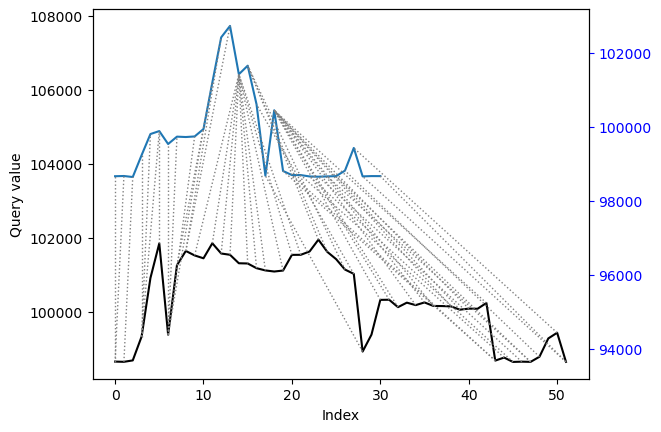

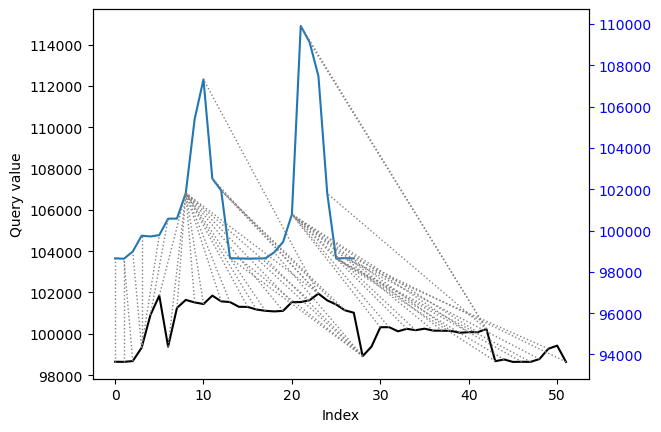

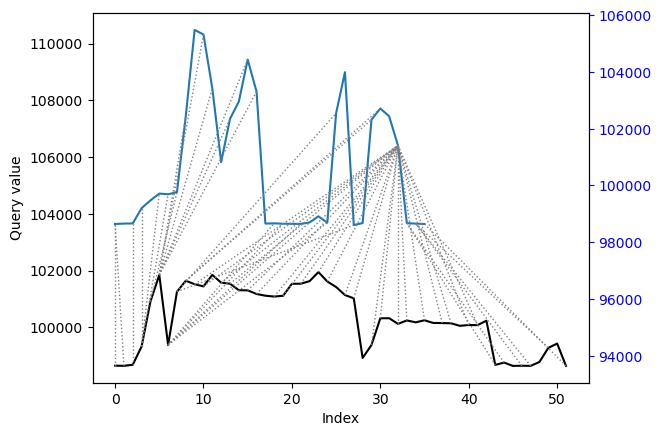

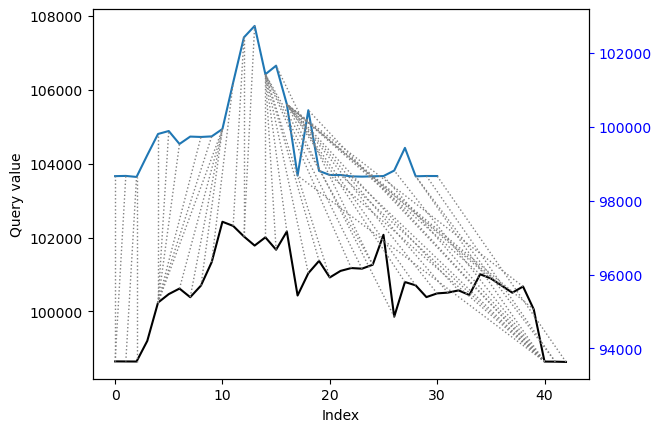

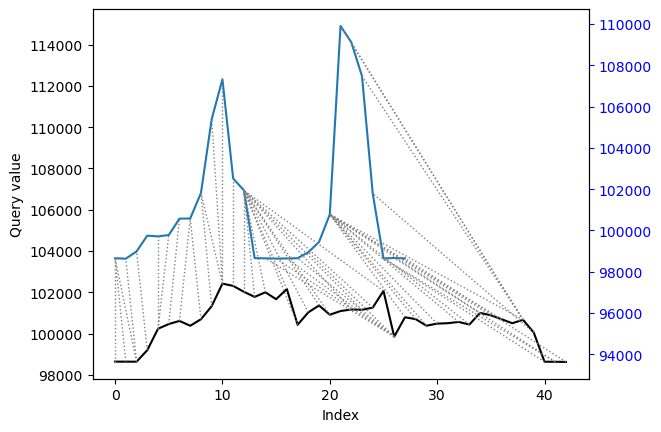

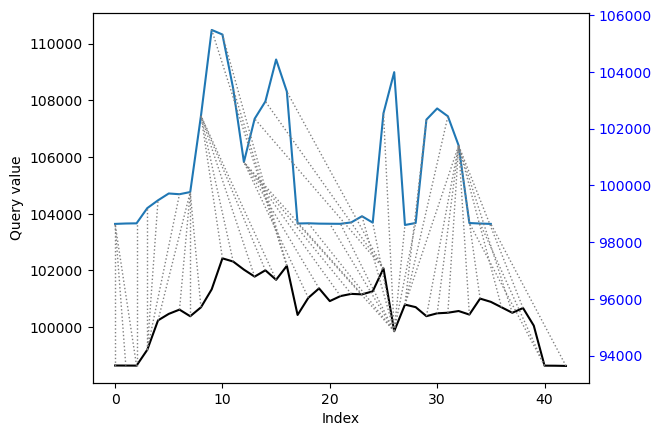

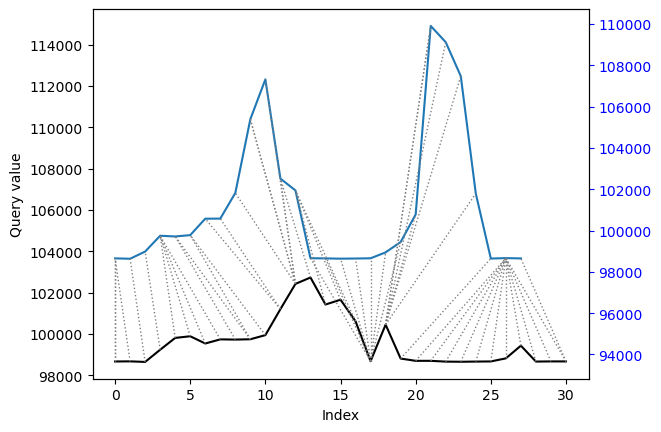

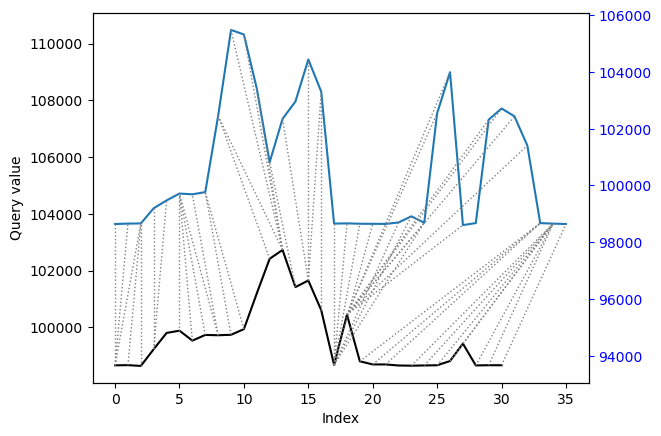

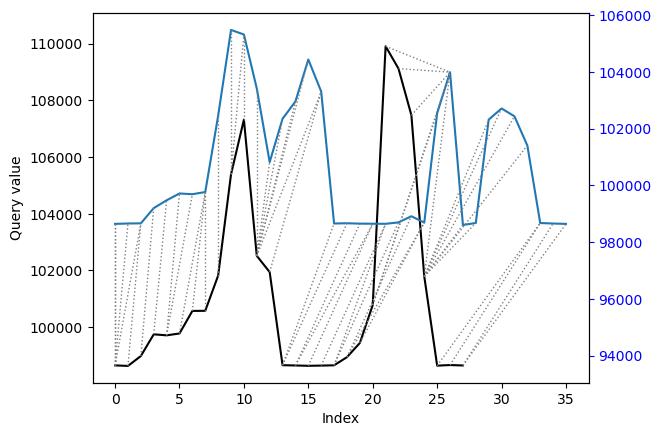

In [ ]:
import pandas as pd
import os
from dtw import *

def load_data(filepath):
    #basepath = '/content/drive/MyDrive/The Hybrid Atelier/REU2024/1 - Project Folders/Rohita & Roy/2 - Data Collection/Collab Data Visualization/'

    if not os.path.isfile(filepath):
        print(f"{filepath} not working.")

    # reads all the data into the data frame along with all the varaiables
    column_names = [
        "time (ms)","pressure (kPa)"
    ]
    data = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels
    #print(data)
    #will basically equalize the time
    #data["time (ms)"] = data["time (ms)"] - data["time (ms)"].iloc[0]
    return data["pressure (kPa)"].to_numpy()



# bend2 = load_data('bend2.csv')
# bend3 = load_data('bend3.csv')
# roh_bend = load_data('RohL_bend1.csv')
bends = []
filepaths = ['RohL_bend1dtwfiltered.csv', 'RohL_rbend2dtwfiltered.csv', 'bend1dtwfiltered.csv', 'bend2dtwfiltered.csv', 'bend3dtwfiltered.csv']
for filepath in filepaths:
    bends.append(load_data(filepath))
    #print(bends)

offsetamount = 5000
dtws = []
count = 1
for i in range(len(filepaths)):
    count = 0
    for j in bends[i+1:]:
        alignment = dtw(bends[i], j, keep_internals=True)
        print(filepaths[i], end=" ")
        print(filepaths[i+1:][count], end=": ")
        print(alignment.normalizedDistance)
        dtwPlotTwoWay(d=alignment, offset=offsetamount)
        dtws.append(dtw(bends[i], j, keep_internals=True))
        count+=1
        
# alignment = dtw(bends[0], bends[2], keep_internals=True)
# print(alignment.normalizedDistance)

#sns.lineplot()
# print(alignment3.normalizedDistance)
# alignment.plot(type="twoway")
# alignment2 = dtw(roh_bend, bend3, keep_internals=True, 
#     step_pattern=rabinerJuangStepPattern(6, "c"))
# alignment2.plot(type="twoway",offset=-2)
# print(alignment2.normalizedDistance)


## A noisy sine wave as query
# idx = np.linspace(0,6.28,num=100)
# #print(idx)
# query = np.sin(idx) + np.random.uniform(size=100)/10.0
# #print(query)

# ## A cosine is for template; sin and cos are offset by 25 samples
# template = np.cos(idx)
#print(template)

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x600 with 0 Axes>

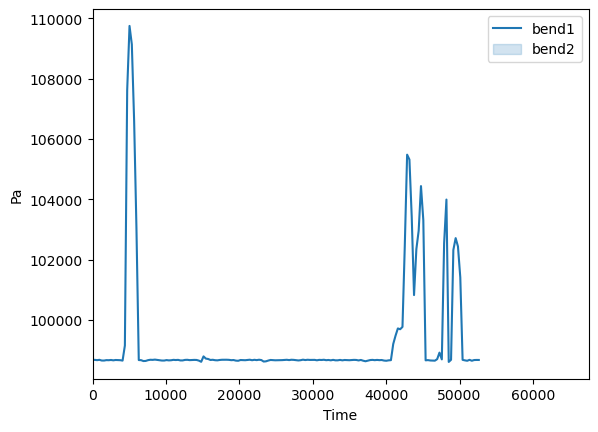

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


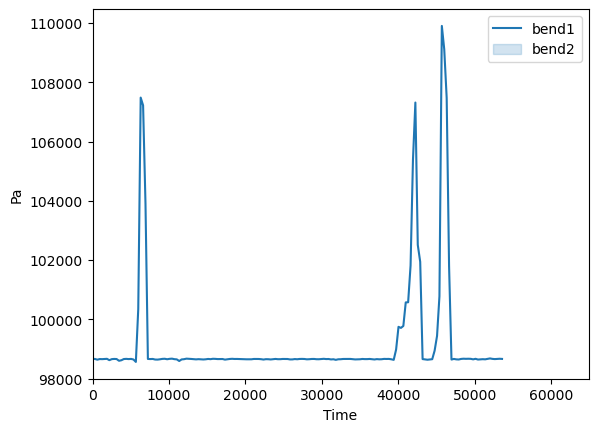

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


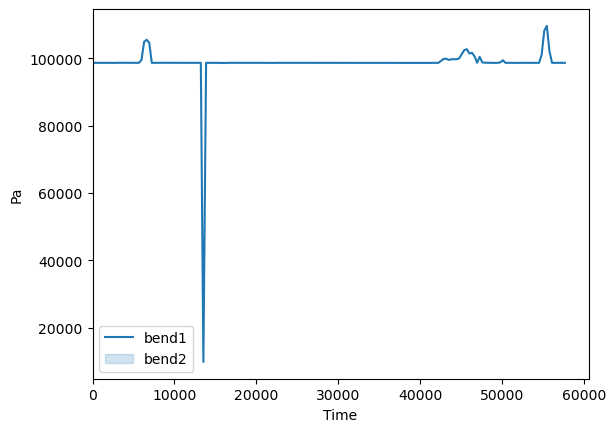

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

def read_and_plot(filepaths):
    #basepath = '/content/drive/MyDrive/The Hybrid Atelier/REU2024/1 - Project Folders/Rohita & Roy/2 - Data Collection/Collab Data Visualization/'
    plt.figure(figsize=(12, 6))#size of the data plot

    for filepath in filepaths:
        #filepath = basepath + filepath
        if not os.path.isfile(filepath):
            print(f"{filepath} not working.")
            continue

        # reads all the data into the data frame along with all the varaiables
        column_names = [
            "Time", "Acc_X", "Acc_Y", "Acc_Z","Gyr_X", "Gyr_Y", "Gyr_Z",
            "Mag_X", "Mag_Y", "Mag_Z","Temp", "Pa", "PSI", "atm"
        ]
        data = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels

        #will basically equalize the time
        data["Time"] = data["Time"] - data["Time"].iloc[0]

        # will plot all the points
        # plt.plot(data["Time"], data["Pa"], label=os.path.basename(filepath))
        plt.figure("3 Bends")
        sns.lineplot(data=data, x=data["Time"], y=data["Pa"]).set(xlim=(0, None))
        plt.legend(['bend1', 'bend2', 'bend3'])
        plt.show()
    # plt.xlabel('Time')
    # plt.ylabel('pressure (kPa)')
    # plt.title('Pressure over Time')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

if __name__ == "__main__":
    #filepaths = ["bt1.csv", "bt2.csv", "bt3.csv"]
    filepaths = ["bend3.csv", "bend2.csv", "bend1.csv"] #all the files i want in the graph
    read_and_plot(filepaths)